In [1]:
## Librerias
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold,RepeatedKFold,train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import Input, Model, optimizers,regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dense,\
                                    Conv2D,\
                                    BatchNormalization,\
                                    AveragePooling2D, \
                                    MaxPooling2D, \
                                    DepthwiseConv2D, \
                                    Activation, \
                                    Dropout,\
                                    Flatten

In [2]:
## Cargar data de training y test 

def get_dataset(dir_task,num_class):
    """
    Construye el dataset a partir de la direccion de carpetas y la cantidad de clases
    a clasificar.
    
    Argumentos: dir_task(Direccion de carpetas) y num_class(cantidad de clases)
    Output: inputs(imagenes) y targets(vector de clases) 
    """
    
    train_dir = os.path.join(dir_task, "train_data")
    test_dir = os.path.join(dir_task, "test_data")
    
    type_class = 'binary'
    if (num_class != 2):
        type_class = 'sparse'
    
    datagen_task = ImageDataGenerator(rescale=1./255)

    # Train
    
    data_task = datagen_task.flow_from_directory(
        train_dir, 
        batch_size = 100,
        target_size=(128, 128),
        class_mode = type_class,
        color_mode="rgb"
        )
    
    num_samples = 0
    for i in range(len(data_task)):
        num_samples += len(data_task[i][1]) 


    X_train = np.zeros(shape=(num_samples, 128, 128, 3))
    Y_train = np.zeros(shape=(num_samples))
    i=0

    for inputs_batch,labels_batch in data_task:
        X_train[i * 100 : (i + 1) * 100] =  inputs_batch
        Y_train[i * 100 : (i + 1) * 100] = labels_batch
        i += 1
        if i * 100 >= num_samples:
            break
    
    # Test
    
    test_task = datagen_task.flow_from_directory(
        test_dir, 
        batch_size = 100,
        target_size=(128, 128),
        class_mode = type_class
        )
    
    num_samples = 0
    for i in range(len(test_task)):
        num_samples += len(test_task[i][1]) 
    
    X_test = np.zeros(shape=(num_samples, 128, 128, 3))
    Y_test = np.zeros(shape=(num_samples))
    i=0

    for inputs_batch,labels_batch in test_task:
        X_test[i * 100 : (i + 1) * 100] =  inputs_batch
        Y_test[i * 100 : (i + 1) * 100] = labels_batch
        i += 1
        if i * 100 >= num_samples:
            break
    
    return X_train,X_test,Y_train,Y_test

In [3]:
def get_dataset_v2(dir_task,num_class):
    """
    Construye el dataset a partir de la direccion de carpetas y la cantidad de clases
    a clasificar. La versión 2 get_dataset obtiene las imagenes de las dos clases de forma ordenada por repeticiones/canales
    
    Argumentos: dir_task(Direccion de carpetas) y num_class(cantidad de clases)
    Output: inputs(imagenes) y targets(vector de clases) 
    """
    
    train_dir = os.path.join(dir_task, "train_data")
    test_dir = os.path.join(dir_task, "test_data")
    
    # Training
    
    X_train1 = np.zeros(shape=(25,128, 128, 3))
    X_train2 = np.zeros(shape=(25,128, 128, 3))
    X_train3 = np.zeros(shape=(25,128, 128, 3))
    
    fnames_tasks = [os.path.join(train_dir,fname) for fname in os.listdir(train_dir)]
    
    fnames = [os.path.join(fnames_tasks[0],fname) for fname in os.listdir(fnames_tasks[0])]
    for i in range(0,25):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_train1[i] = x
    
    fnames = [os.path.join(fnames_tasks[1],fname) for fname in os.listdir(fnames_tasks[1])]
    for i in range(0,25):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_train2[i] = x
    
    fnames = [os.path.join(fnames_tasks[2],fname) for fname in os.listdir(fnames_tasks[2])]
    for i in range(0,25):
        img_path = fnames[i]
        img = image.load_img(img_path,target_size=(128,128))
        x = image.img_to_array(img)
        x = x.astype('float32') / 255
        X_train3[i] = x
   
    X_train = np.concatenate((X_train1,X_train2,X_train3),axis = 0)
    
    Y_task1 = np.zeros((25,), dtype=np.float64)
    Y_task2 = np.ones((25,), dtype=np.float64)
    Y_task3 = 2*np.ones((25,), dtype=np.float64)
    
    Y_train = np.concatenate((Y_task1,Y_task2,Y_task3))
    # Testing
    
    type_class = 'binary'
    if (num_class != 2):
        type_class = 'sparse'
    
    datagen_task = ImageDataGenerator(rescale=1./255)
    
    test_task = datagen_task.flow_from_directory(
        test_dir, 
        batch_size = 100,
        target_size=(128, 128),
        class_mode = type_class
        )
    
    num_samples = 0
    for i in range(len(test_task)):
        num_samples += len(test_task[i][1]) 
    
    X_test = np.zeros(shape=(num_samples, 128, 128, 3))
    Y_test = np.zeros(shape=(num_samples))
    i=0

    for inputs_batch,labels_batch in test_task:
        X_test[i * 100 : (i + 1) * 100] =  inputs_batch
        Y_test[i * 100 : (i + 1) * 100] = labels_batch
        i += 1
        if i * 100 >= num_samples:
            break
            
    return X_train,X_test,Y_train,Y_test

In [4]:
def EEGNet_model(num_class):
    """
    Construye una EEGNet utilizando Tensorflow de forma secuencial.
    
    Argumentos: num_class
    Output: EEGNet como modelo de Tensorflow.keras
    """
    
    
    EEGNet = tf.keras.Sequential()

    # Block1
    regularizers.l2(1e-4)
    EEGNet.add(Conv2D(4, (1, 125),
                        padding='same',
                        use_bias=False,
                        name='tfconv',input_shape = (128,128,3)))
    EEGNet.add(BatchNormalization(axis=-1))
    EEGNet.add(DepthwiseConv2D((6, 1),
                             use_bias=False,
                             depth_multiplier=2,
                             depthwise_constraint=max_norm(1.),
                             name='sconv'))
    EEGNet.add(BatchNormalization(axis=-1))
    EEGNet.add(Activation('elu'))
    EEGNet.add(AveragePooling2D((1, 4)))
    EEGNet.add(Dropout(0.5))

    # Block 2

    EEGNet.add(Conv2D(8, (1, 32),
                             padding='same',
                             use_bias=False,
                             name='fs',
                             kernel_regularizer='l2'
                     ))
    EEGNet.add(BatchNormalization(axis=-1))
    EEGNet.add(Activation('elu'))
    EEGNet.add(AveragePooling2D((1, 8)))
    EEGNet.add(Dropout(0.5))

    # Output

    EEGNet.add(Flatten(name='flatten'))

    EEGNet.add(Dense(num_class,
                  name='dense',
                  kernel_constraint=max_norm(0.25)))
    EEGNet.add(Activation('softmax', name='softmax'))

    return EEGNet

In [5]:
def get_compile(model: tf.keras.Model):
    """
    Compila el modelo con un optimizador Adam (lr = 0.001), loss categorico y como metrica el accuracy
    
    Argumentos: CNN como modelo
    Output: Modelo compilado
    """
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
    return model

In [6]:
def get_EEGNet(num_class):
    """
    Crea y compila una EEGNet lista para entrenarla y clasificar. Se adapta según la 
    cantidad de clases
    
    Argumentos: num_class
    Output: modelo listo 
    """
    
    model = EEGNet_model(num_class)
    model = get_compile(model)
    
    return model

In [7]:
def plot_acc(history,fold):
    plt.title('Train Accuracy vs Val Accuracy Fold:' + str(fold))
    plt.plot(history.history['acc'], label='Train Accuracy Fold ', color='black')
    plt.plot(history.history['val_acc'], label='Val Accuracy Fold ', color='red', linestyle = "dashdot")
    plt.legend()
    plt.show()
    
def plot_loss(history,fold):
    plt.title('Train Loss vs Val Loss Fold:' + str(fold))
    plt.plot(history.history['loss'], label='Train Loss Fold ', color='black')
    plt.plot(history.history['val_loss'], label='Val Loss Fold ', color='red', linestyle = "dashdot")
    plt.legend()
    plt.show()
    
def plot_metrics(history,fold):
    plot_acc(history,fold)
    plot_loss(history,fold)

In [8]:
def print_subject_results(val_per_fold,acc_per_fold,repetitions):
    """
    Imprime los accuracy conseguido en cada Fold y calcula el acc y loss promedio de los folds de cada run
    
    Argumentos: Vector de loss dim(folds * repeticiones)
                Vector de accuracy 
    Output: Acc promedio final
            Std promedio final
    """
    
    test_score_final = []
    val_score_final = []
    print('******************')
    print('Precision por run')
    print('**************************')
    print('*Val_acc --------Test_acc*')
    for i in range(0,repetitions):
        max_per_fold = max(acc_per_fold[0*i:5*(i+1)])
        test_score_final.append(max_per_fold[1])
        val_score_final.append(np.mean(val_per_fold[0*i:5*(i+1)]))

    val_mean = np.mean(val_score_final)    
    val_std = np.std(val_score_final)
    test_mean = np.mean(test_score_final)
    test_std = np.std(test_score_final)
        
    print(f'Val Accuracy:{val_mean*100} +- {val_std*100}')
    print(f'Test Accuracy:{test_mean*100} +- {test_std*100}')
    
    return val_mean,val_std,test_mean,test_std

In [9]:
def Kcross_validation(num_class,X_train,X_test,Y_train,Y_test,repetitions):
    """
    Aplica Repeated K-cross validation considerando la repeticiones deseadas
    
    Argumentos: num_class
                inputs(imagenes)
                targets(clases)
                repetitions
                
    Output: val_mean,val_std,test_mean,test_std
    """
    
    # Per-fold score containers 
    acc_per_fold = []
    val_per_fold = []
    kfold = RepeatedKFold(n_splits = 5, n_repeats = repetitions)
    fold_n = 1
    
    for train,val in kfold.split(X_train,Y_train):
        EEGNet = get_EEGNet(num_class)
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_n} ...')

        pat = 25
        early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=pat, verbose=1)
        model_checkpoint = ModelCheckpoint('./model_checkpoint', verbose=1, save_best_only=True, monitor='val_acc',
        mode='max')
        
        history = EEGNet.fit(X_train[train] , Y_train[train], 
                             epochs = 50, steps_per_epoch = 2, validation_data = (X_train[val],Y_train[val]), 
                             callbacks=[early_stopping, model_checkpoint]
                            )
        plot_metrics(history,fold_n)
    
        EGGNetnew = tf.keras.models.load_model('./model_checkpoint')
        val_scores = EGGNetnew.evaluate(X_train[val],Y_train[val],verbose=0)
        test_scores = EGGNetnew.evaluate(X_test,Y_test,verbose=0)

        print(f'Val-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {val_scores[0]}; {EEGNet.metrics_names[1]} of {val_scores[1]*100}%')
        print(f'Test-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {test_scores[0]}; {EEGNet.metrics_names[1]} of {test_scores[1]*100}%')
        acc_per_fold.append((val_scores[1],test_scores[1]))
        val_per_fold.append(val_scores[1])

        # Increse number of fold

        fold_n = fold_n + 1
    
    val_mean,val_std,test_mean,test_std = print_subject_results(val_per_fold,acc_per_fold,repetitions)
    
    return val_mean,val_std,test_mean,test_std

In [10]:
def Kcross_validation_v2(num_class,X_train,X_test,Y_train,Y_test,repetitions):
    """
    Aplica Repeated K-cross validation considerando la repeticiones deseadas. Separa training y validation por canales 
    donde se valida con 1 canal. El canal utilizado en testeo se obtiene ya desde get_dataset
    
    Argumentos: num_class
                inputs(imagenes)
                targets(clases)
                repetitions
                
    Output: val_mean,val_std,test_mean,test_std
        
    """
    
    # Per-fold score containers 
    acc_per_fold = []
    val_per_fold = []
    kfold = RepeatedKFold(n_splits = 5, n_repeats = repetitions)
    
    fold_n = 1
    list_channels = np.array([0,1,2,3,4])
    step_per_chn = 5
    
    for train,val in kfold.split(list_channels):
        
        train_index = np.zeros(shape = 0)
        val_index = np.zeros(shape = 0)

        for i in train:
            temp = range(i*step_per_chn,(i+1)*step_per_chn)
            train_index = np.concatenate((train_index,temp))

        for k in val:
            temp = range(k*step_per_chn,(k+1)*step_per_chn)
            val_index = np.concatenate((val_index,temp))
        
        train_index = np.concatenate((train_index,train_index+25,train_index+50))
        val_index = np.concatenate((val_index,val_index+25,val_index+50))

        np.random.shuffle(train_index)
        np.random.shuffle(val_index)
        
        train_index = train_index.astype(int)
        val_index = val_index.astype(int)
        
        EEGNet = get_EEGNet(num_class)
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_n} and Validating with Chn {val[0]+1}')

        pat = 25
        early_stopping = EarlyStopping(monitor='val_acc', mode='max', patience=pat, verbose=1)
        model_checkpoint = ModelCheckpoint('./model_checkpoint', verbose=1, save_best_only=True, monitor='val_acc',
        mode='max')
        
        history = EEGNet.fit(X_train[train_index] , Y_train[train_index], 
                             epochs = 50, steps_per_epoch = 2, validation_data = (X_train[val_index],Y_train[val_index]), 
                             callbacks=[early_stopping, model_checkpoint]
                            )
        plot_metrics(history,fold_n)
    
        EGGNetnew = tf.keras.models.load_model('./model_checkpoint')
        val_scores = EGGNetnew.evaluate(X_train[val_index],Y_train[val_index],verbose=0)
        test_scores = EGGNetnew.evaluate(X_test,Y_test,verbose=0)
    
        print(f'Val-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {val_scores[0]}; {EEGNet.metrics_names[1]} of {val_scores[1]*100}%')
        print(f'Test-Score for fold {fold_n}: {EEGNet.metrics_names[0]} of {test_scores[0]}; {EEGNet.metrics_names[1]} of {test_scores[1]*100}%')
        acc_per_fold.append((val_scores[1],test_scores[1]))
        val_per_fold.append(val_scores[1])
        
         # Increse number of fold
        fold_n = fold_n + 1
        
    val_mean,val_std,test_mean,test_std = print_subject_results(val_per_fold,acc_per_fold,repetitions)
    
    return val_mean,val_std,test_mean,test_std

Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 5s 859ms/step - loss: 1.5028 - acc: 0.2000 - val_loss: 1.1742 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 669ms/step - loss: 1.1652 - acc: 0.4000 - val_loss: 1.1608 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 688ms/step - loss: 0.9980 - acc: 0.6667 - val_loss: 1.1453 - val_acc: 0.8000

Epoch 00003: val_acc improved from 0.40000 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\asset

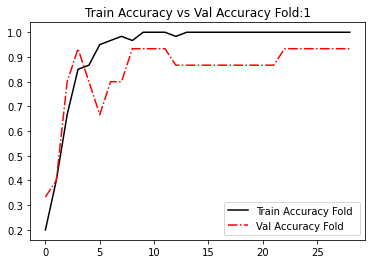

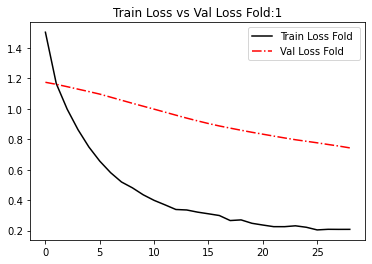

Val-Score for fold 1: loss of 1.1291354894638062; acc of 93.33333373069763%
Test-Score for fold 1: loss of 1.1103988885879517; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 773ms/step - loss: 1.2986 - acc: 0.3833 - val_loss: 1.1705 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 704ms/step - loss: 1.1104 - acc: 0.4000 - val_loss: 1.1510 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 674ms/step - loss: 0.9310 - acc: 0.7833 - val_loss: 1.1296 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.53333 to 0.

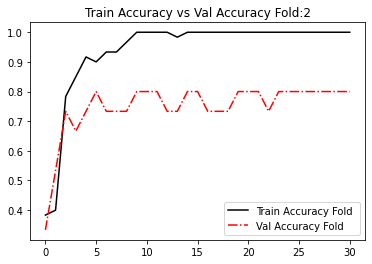

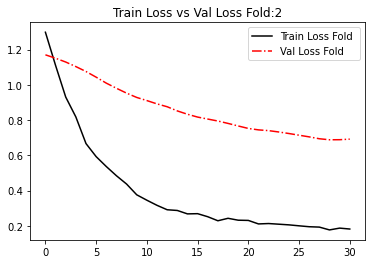

Val-Score for fold 2: loss of 1.0436346530914307; acc of 80.0000011920929%
Test-Score for fold 2: loss of 1.046305537223816; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 869ms/step - loss: 1.1932 - acc: 0.4167 - val_loss: 1.1651 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 737ms/step - loss: 1.0568 - acc: 0.6000 - val_loss: 1.1426 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 781ms/step - loss: 0.9343 - acc: 0.8167 - val_loss: 1.1207 - val_acc: 0.4667

Epoch 00003: val_acc did not improve fr

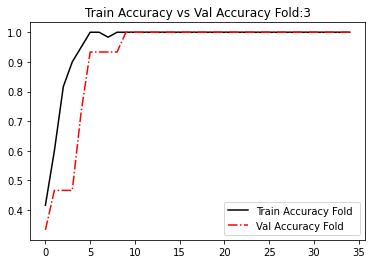

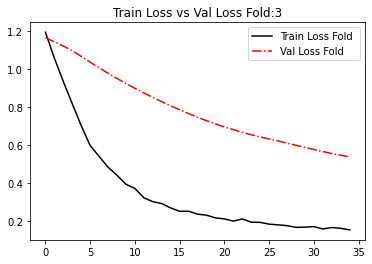

Val-Score for fold 3: loss of 0.9236021041870117; acc of 100.0%
Test-Score for fold 3: loss of 0.9092592000961304; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 878ms/step - loss: 1.3442 - acc: 0.3000 - val_loss: 1.1713 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 753ms/step - loss: 1.1140 - acc: 0.4500 - val_loss: 1.1533 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 731ms/step - loss: 0.9748 - acc: 0.6333 - val_loss: 1.1364 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50

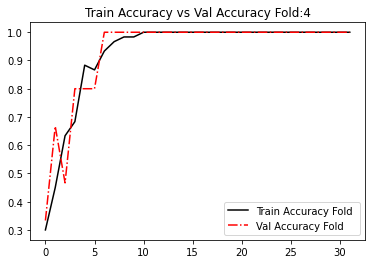

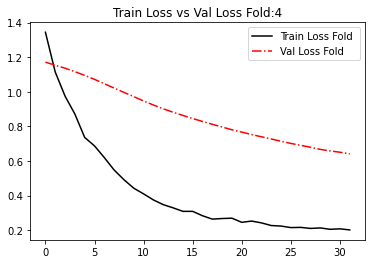

Val-Score for fold 4: loss of 1.0467149019241333; acc of 100.0%
Test-Score for fold 4: loss of 1.023206114768982; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 955ms/step - loss: 1.3574 - acc: 0.3333 - val_loss: 1.1772 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 735ms/step - loss: 1.1127 - acc: 0.4500 - val_loss: 1.1572 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 720ms/step - loss: 0.9602 - acc: 0.8833 - val_loss: 1.1368 - val_acc: 0.4000

Epoch 00003: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets


2/2 [==============================] - 1s 697ms/step - loss: 0.1393 - acc: 1.0000 - val_loss: 0.7728 - val_acc: 0.6000

Epoch 00042: val_acc did not improve from 0.60000
Epoch 43/50
2/2 [==============================] - 1s 682ms/step - loss: 0.1389 - acc: 1.0000 - val_loss: 0.7561 - val_acc: 0.6000

Epoch 00043: val_acc did not improve from 0.60000
Epoch 44/50
2/2 [==============================] - 1s 669ms/step - loss: 0.1425 - acc: 1.0000 - val_loss: 0.7369 - val_acc: 0.6667

Epoch 00044: val_acc improved from 0.60000 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 45/50
2/2 [==============================] - 1s 664ms/step - loss: 0.1350 - acc: 1.0000 - val_loss: 0.7163 - val_acc: 0.6667

Epoch 00045: val_acc did not improve from 0.66667
Epoch 46/50
2/2 [==============================] - 1s 708ms/step - loss: 0.1373 - acc: 1.0000 - val_loss: 0.7173 - val_acc: 0.6667

Epoch 00046: val_acc did not improve from 0.66667
E

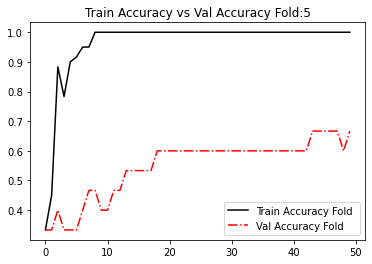

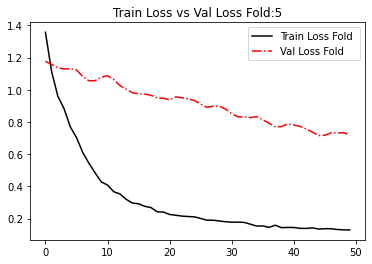

Val-Score for fold 5: loss of 0.7368623614311218; acc of 66.66666865348816%
Test-Score for fold 5: loss of 0.42711108922958374; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:88.00000071525574 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 827ms/step - loss: 1.3843 - acc: 0.3000 - val_loss: 1.1670 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 728ms/step - loss: 1.0989 - acc: 0.5333 - val_loss: 1.1473 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.33333 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written 

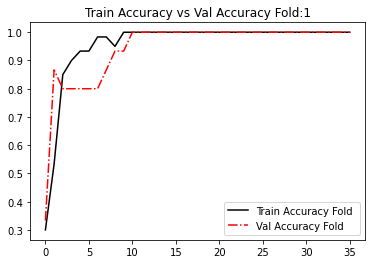

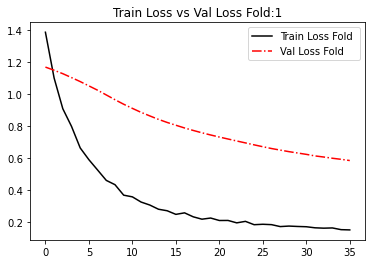

Val-Score for fold 1: loss of 0.9097570776939392; acc of 100.0%
Test-Score for fold 1: loss of 0.9219910502433777; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 865ms/step - loss: 1.2470 - acc: 0.3833 - val_loss: 1.1745 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 721ms/step - loss: 1.0602 - acc: 0.5000 - val_loss: 1.1548 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 730ms/step - loss: 0.8980 - acc: 0.8500 - val_loss: 1.1317 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 733ms/step - loss: 0.7655 - acc: 0.8500 - val_

2/2 [==============================] - 1s 699ms/step - loss: 0.1403 - acc: 1.0000 - val_loss: 0.6668 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.86667
Epoch 41/50
2/2 [==============================] - 1s 750ms/step - loss: 0.1406 - acc: 1.0000 - val_loss: 0.6591 - val_acc: 1.0000

Epoch 00041: val_acc improved from 0.86667 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 42/50
2/2 [==============================] - 1s 728ms/step - loss: 0.1351 - acc: 1.0000 - val_loss: 0.6574 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 726ms/step - loss: 0.1315 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 685ms/step - loss: 0.1343 - acc: 1.0000 - val_loss: 0.6525 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
E

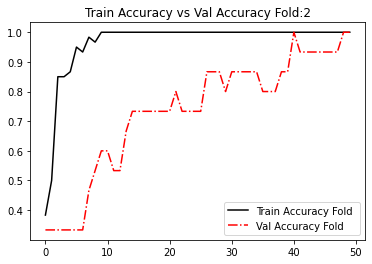

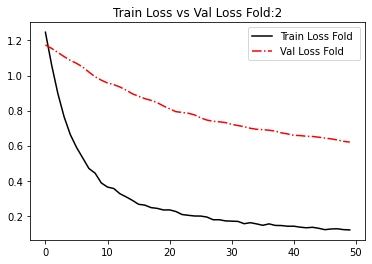

Val-Score for fold 2: loss of 0.6590864658355713; acc of 100.0%
Test-Score for fold 2: loss of 0.5483224391937256; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 794ms/step - loss: 1.2148 - acc: 0.4167 - val_loss: 1.1743 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 693ms/step - loss: 1.1315 - acc: 0.4667 - val_loss: 1.1596 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 664ms/step - loss: 0.9511 - acc: 0.7167 - val_loss: 1.1445 - val_acc: 0.5333

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50

2/2 [==============================] - 1s 704ms/step - loss: 0.1516 - acc: 1.0000 - val_loss: 0.6325 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 706ms/step - loss: 0.1465 - acc: 1.0000 - val_loss: 0.6266 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 724ms/step - loss: 0.1421 - acc: 1.0000 - val_loss: 0.6224 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 808ms/step - loss: 0.1320 - acc: 1.0000 - val_loss: 0.6194 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 764ms/step - loss: 0.1380 - acc: 1.0000 - val_loss: 0.6155 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 714ms/step - loss: 0.1339 - acc: 1.0000 - val_lo

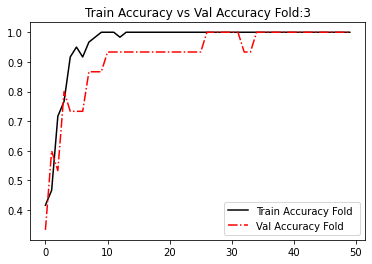

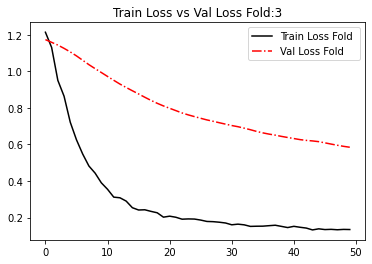

Val-Score for fold 3: loss of 0.7345262169837952; acc of 100.0%
Test-Score for fold 3: loss of 0.6765395402908325; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 875ms/step - loss: 1.2042 - acc: 0.3833 - val_loss: 1.1719 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 678ms/step - loss: 1.1395 - acc: 0.4667 - val_loss: 1.1596 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 690ms/step - loss: 1.0639 - acc: 0.7000 - val_loss: 1.1482 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50

2/2 [==============================] - 1s 670ms/step - loss: 0.1304 - acc: 1.0000 - val_loss: 0.5602 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 753ms/step - loss: 0.1353 - acc: 1.0000 - val_loss: 0.5580 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 691ms/step - loss: 0.1346 - acc: 1.0000 - val_loss: 0.5551 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 674ms/step - loss: 0.1265 - acc: 1.0000 - val_loss: 0.5509 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 681ms/step - loss: 0.1264 - acc: 1.0000 - val_loss: 0.5471 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 719ms/step - loss: 0.1246 - acc: 1.0000 - val_lo

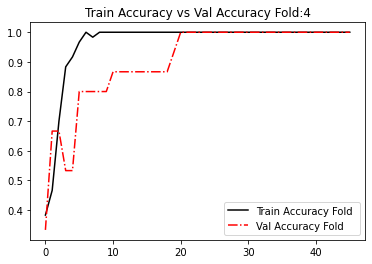

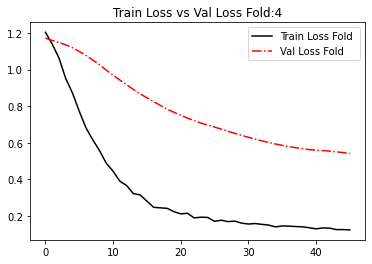

Val-Score for fold 4: loss of 0.7511674165725708; acc of 100.0%
Test-Score for fold 4: loss of 0.806161105632782; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 910ms/step - loss: 1.3336 - acc: 0.4333 - val_loss: 1.1642 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 681ms/step - loss: 1.0399 - acc: 0.5833 - val_loss: 1.1477 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.40000 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 680ms/step - loss: 0.8813 - acc: 0.7500 - val_loss: 1.1306 - val_acc: 0.8000

Epoch 00003: val_acc improved from 0.53333 to 0.8

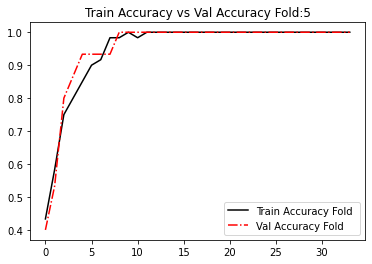

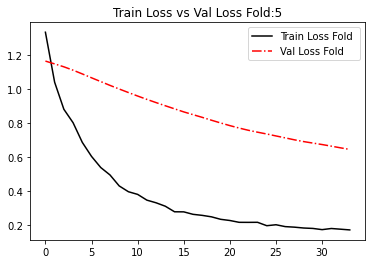

Val-Score for fold 5: loss of 1.0003104209899902; acc of 100.0%
Test-Score for fold 5: loss of 0.9866583347320557; acc of 100.0%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:100.0 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 814ms/step - loss: 1.2843 - acc: 0.3667 - val_loss: 1.1736 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 678ms/step - loss: 1.1578 - acc: 0.3333 - val_loss: 1.1569 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3

2/2 [==============================] - 2s 800ms/step - loss: 0.1605 - acc: 1.0000 - val_loss: 0.6330 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 771ms/step - loss: 0.1517 - acc: 1.0000 - val_loss: 0.6250 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 2s 855ms/step - loss: 0.1587 - acc: 1.0000 - val_loss: 0.6107 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 757ms/step - loss: 0.1471 - acc: 1.0000 - val_loss: 0.5990 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 845ms/step - loss: 0.1599 - acc: 1.0000 - val_loss: 0.5913 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 00044: early stopping


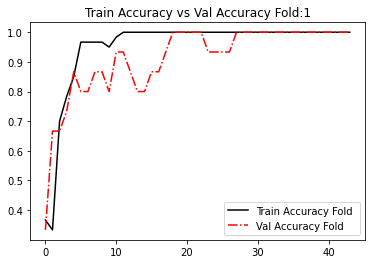

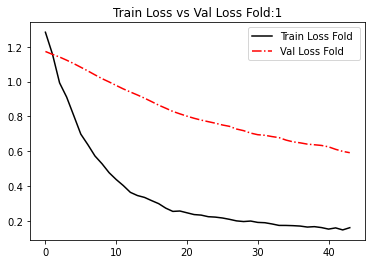

Val-Score for fold 1: loss of 0.8287626504898071; acc of 100.0%
Test-Score for fold 1: loss of 0.8372541666030884; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 1s/step - loss: 1.3883 - acc: 0.3833 - val_loss: 1.1690 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 855ms/step - loss: 1.0813 - acc: 0.4000 - val_loss: 1.1531 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 825ms/step - loss: 0.9231 - acc: 0.7667 - val_loss: 1.1383 - val_acc: 0.9333

Epoch 00003: val_acc improved from 0.60000 to 0.93333, saving m

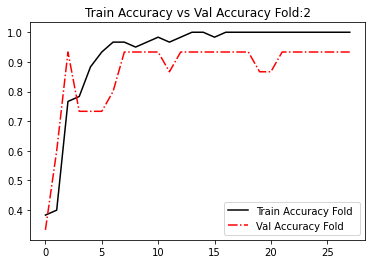

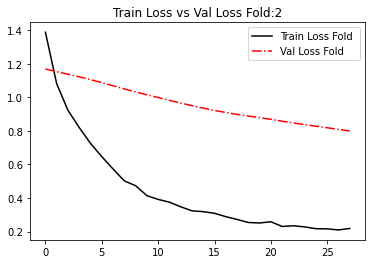

Val-Score for fold 2: loss of 1.138289213180542; acc of 93.33333373069763%
Test-Score for fold 2: loss of 1.1220018863677979; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 1s/step - loss: 1.2963 - acc: 0.3000 - val_loss: 1.1702 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 885ms/step - loss: 1.0693 - acc: 0.6667 - val_loss: 1.1529 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 885ms/step - loss: 1.0000 - acc: 0.6500 - val_loss: 1.1338 - val_acc: 0.5333

Epoch 00003: val_acc did not improve from 0.53333
Ep

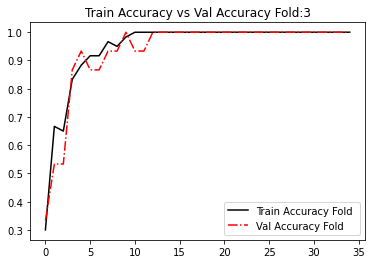

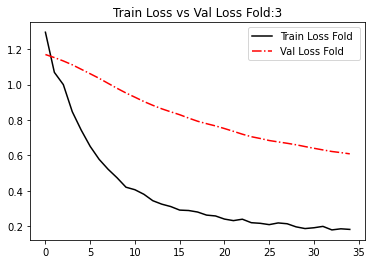

Val-Score for fold 3: loss of 0.9526151418685913; acc of 100.0%
Test-Score for fold 3: loss of 0.9510983228683472; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 790ms/step - loss: 1.4071 - acc: 0.2167 - val_loss: 1.1734 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 724ms/step - loss: 1.1361 - acc: 0.4833 - val_loss: 1.1667 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 711ms/step - loss: 0.9829 - acc: 0.7333 - val_loss: 1.1603 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.53333 to 0.60000, savin

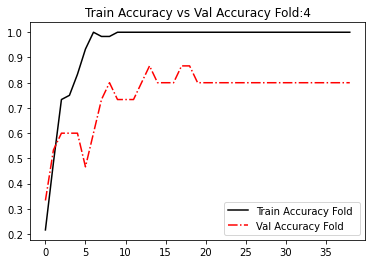

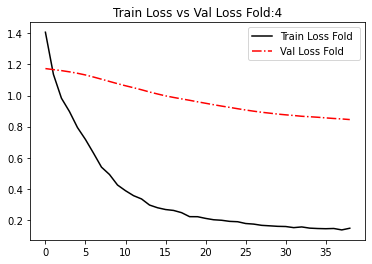

Val-Score for fold 4: loss of 1.0227837562561035; acc of 86.66666746139526%
Test-Score for fold 4: loss of 0.950963020324707; acc of 100.0%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 822ms/step - loss: 1.2789 - acc: 0.3500 - val_loss: 1.1715 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 700ms/step - loss: 1.0959 - acc: 0.4167 - val_loss: 1.1628 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 736ms/step - loss: 0.9838 - acc: 0.7667 - val_loss: 1.1537 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0.46667 to 0.8

2/2 [==============================] - 1s 664ms/step - loss: 0.1573 - acc: 1.0000 - val_loss: 0.6868 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 695ms/step - loss: 0.1585 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 00043: early stopping


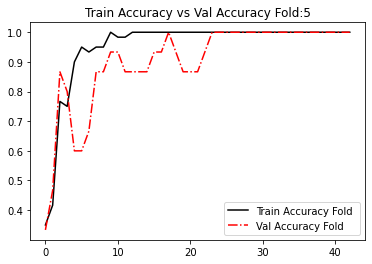

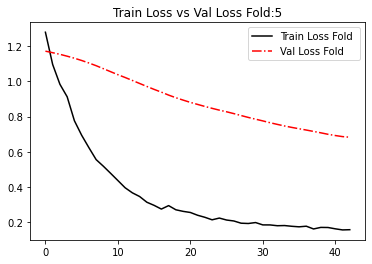

Val-Score for fold 5: loss of 0.9223033785820007; acc of 100.0%
Test-Score for fold 5: loss of 0.9134897589683533; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:96.00000023841858 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 909ms/step - loss: 1.2515 - acc: 0.3500 - val_loss: 1.1736 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 782ms/step - loss: 1.1750 - acc: 0.4333 - val_loss: 1.1630 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.53333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_c

2/2 [==============================] - 1s 747ms/step - loss: 0.1527 - acc: 1.0000 - val_loss: 0.7450 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.93333
Epoch 41/50
2/2 [==============================] - 1s 747ms/step - loss: 0.1474 - acc: 1.0000 - val_loss: 0.7367 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 670ms/step - loss: 0.1436 - acc: 1.0000 - val_loss: 0.7302 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 700ms/step - loss: 0.1400 - acc: 1.0000 - val_loss: 0.7231 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 737ms/step - loss: 0.1397 - acc: 1.0000 - val_loss: 0.7207 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 765ms/step - loss: 0.1393 - acc: 1.0000 - val_lo

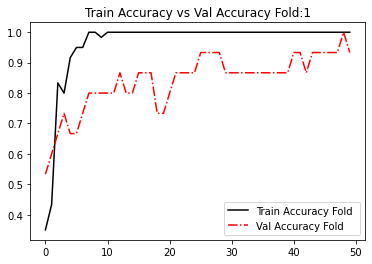

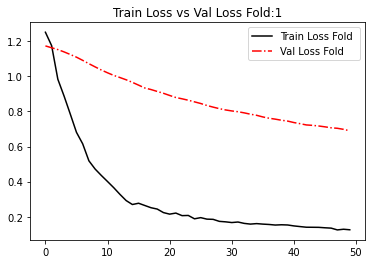

Val-Score for fold 1: loss of 0.6979089379310608; acc of 100.0%
Test-Score for fold 1: loss of 0.5257124304771423; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 888ms/step - loss: 1.4065 - acc: 0.2667 - val_loss: 1.1710 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 774ms/step - loss: 1.0966 - acc: 0.4833 - val_loss: 1.1560 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.46667 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 682ms/step - loss: 0.9794 - acc: 0.7667 - val_loss: 1.1414 - val_acc: 0.8667

Epoch 00003: val_acc did not improve from 0.86667
Epoch 4/50


Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 2s 827ms/step - loss: 0.1504 - acc: 1.0000 - val_loss: 0.5804 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 2s 851ms/step - loss: 0.1617 - acc: 1.0000 - val_loss: 0.5728 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 2s 863ms/step - loss: 0.1558 - acc: 1.0000 - val_loss: 0.5671 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 2s 797ms/step - loss: 0.1420 - acc: 1.0000 - val_loss: 0.5625 - val_acc: 0.9333

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
2/2 [==============================] - 2s 913ms/step - loss: 0.1443 - acc: 1.0000 - val_loss: 0.5577 - val_acc: 0.9333

Epoch 00047: val_acc did not improve from 1.00000
Epoch 48/50
2/2 [======================

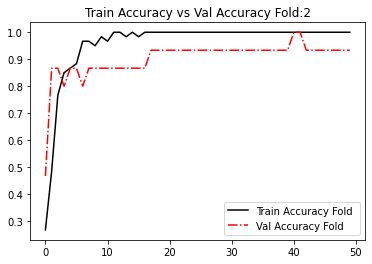

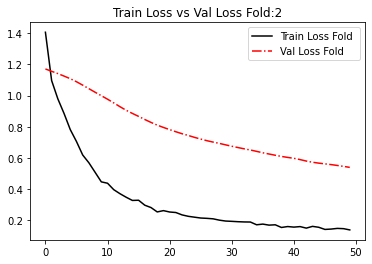

Val-Score for fold 2: loss of 0.5979533791542053; acc of 100.0%
Test-Score for fold 2: loss of 0.5998507738113403; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 926ms/step - loss: 1.2139 - acc: 0.4500 - val_loss: 1.1640 - val_acc: 0.8000

Epoch 00001: val_acc improved from -inf to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 834ms/step - loss: 1.0464 - acc: 0.6333 - val_loss: 1.1427 - val_acc: 0.9333

Epoch 00002: val_acc improved from 0.80000 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 736ms/step - loss: 0.9011 - acc: 0.8000 - val_loss: 1.1186 - val_acc: 0.8000

Epoch 00003: val_acc did not improve from 0.93333
Epoch 4/50

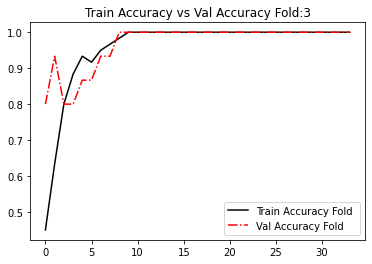

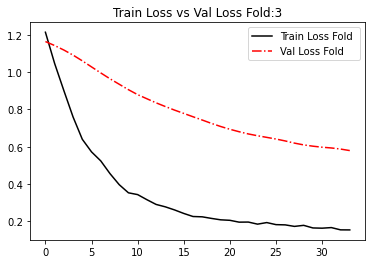

Val-Score for fold 3: loss of 0.9352932572364807; acc of 100.0%
Test-Score for fold 3: loss of 0.9574241042137146; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 840ms/step - loss: 1.2533 - acc: 0.2500 - val_loss: 1.1679 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 711ms/step - loss: 1.0984 - acc: 0.5833 - val_loss: 1.1527 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 696ms/step - loss: 1.0545 - acc: 0.5333 - val_loss: 1.1368 - val_acc: 0.4667

Epoch 00003: val_acc improved from 0.40000 to 0.46667, savin

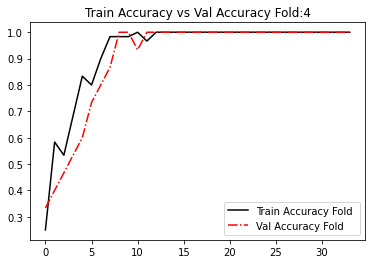

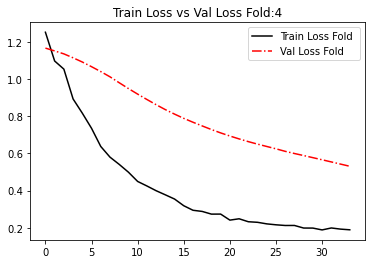

Val-Score for fold 4: loss of 0.9812804460525513; acc of 100.0%
Test-Score for fold 4: loss of 0.9994562268257141; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 796ms/step - loss: 1.2899 - acc: 0.2333 - val_loss: 1.1700 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 740ms/step - loss: 1.0908 - acc: 0.6000 - val_loss: 1.1594 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 777ms/step - loss: 0.9510 - acc: 0.7500 - val_loss: 1.1473 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.40000 to 0.

2/2 [==============================] - 1s 690ms/step - loss: 0.1409 - acc: 1.0000 - val_loss: 0.7077 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 720ms/step - loss: 0.1497 - acc: 1.0000 - val_loss: 0.7003 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 706ms/step - loss: 0.1332 - acc: 1.0000 - val_loss: 0.6913 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 711ms/step - loss: 0.1330 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 709ms/step - loss: 0.1353 - acc: 1.0000 - val_loss: 0.6736 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 704ms/step - loss: 0.1355 - acc: 1.0000 - val_lo

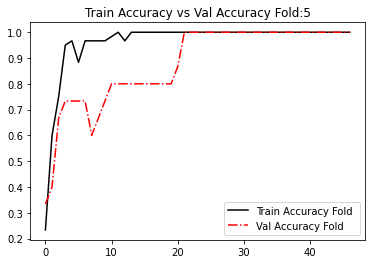

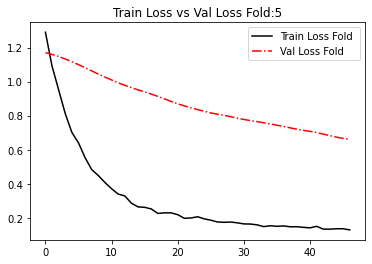

Val-Score for fold 5: loss of 0.8570950031280518; acc of 100.0%
Test-Score for fold 5: loss of 0.7867825627326965; acc of 100.0%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:100.0 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 778ms/step - loss: 1.4243 - acc: 0.2833 - val_loss: 1.1732 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 679ms/step - loss: 1.1085 - acc: 0.5333 - val_loss: 1.1609 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.46667 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3

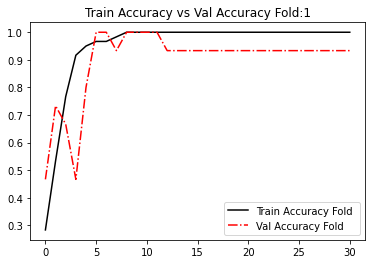

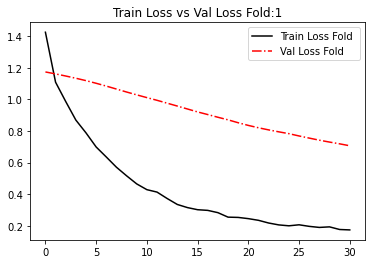

Val-Score for fold 1: loss of 1.101572871208191; acc of 100.0%
Test-Score for fold 1: loss of 1.1264170408248901; acc of 73.33333492279053%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 797ms/step - loss: 1.1921 - acc: 0.3500 - val_loss: 1.1648 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 703ms/step - loss: 1.0324 - acc: 0.6833 - val_loss: 1.1456 - val_acc: 0.9333

Epoch 00002: val_acc improved from 0.40000 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 787ms/step - loss: 0.7992 - acc: 0.9500 - val_loss: 1.1243 - val_acc: 0.8667

Epoch 00003: val_acc did not improve from 0.93333

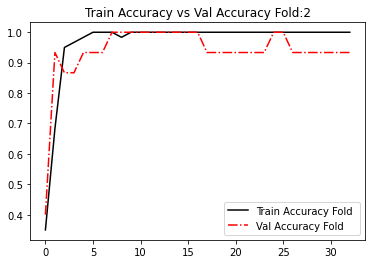

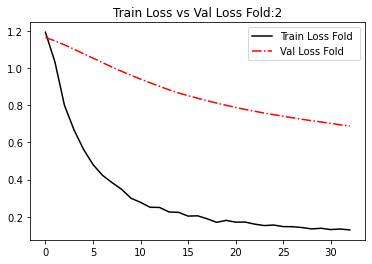

Val-Score for fold 2: loss of 1.0046229362487793; acc of 100.0%
Test-Score for fold 2: loss of 1.0543283224105835; acc of 73.33333492279053%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 837ms/step - loss: 1.2678 - acc: 0.3667 - val_loss: 1.1728 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 820ms/step - loss: 1.0906 - acc: 0.5167 - val_loss: 1.1599 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 687ms/step - loss: 0.9829 - acc: 0.7333 - val_loss: 1.1461 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\asset

2/2 [==============================] - 2s 953ms/step - loss: 0.1269 - acc: 1.0000 - val_loss: 0.5554 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 2s 1s/step - loss: 0.1236 - acc: 1.0000 - val_loss: 0.5502 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 2s 780ms/step - loss: 0.1232 - acc: 1.0000 - val_loss: 0.5412 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 2s 850ms/step - loss: 0.1228 - acc: 1.0000 - val_loss: 0.5308 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 00044: early stopping


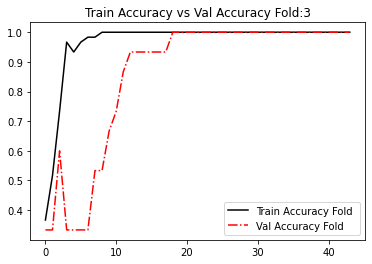

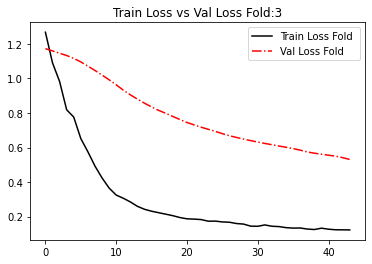

Val-Score for fold 3: loss of 0.7801663875579834; acc of 100.0%
Test-Score for fold 3: loss of 0.8761864304542542; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 872ms/step - loss: 1.3704 - acc: 0.3500 - val_loss: 1.1748 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 719ms/step - loss: 1.0764 - acc: 0.5833 - val_loss: 1.1629 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 702ms/step - loss: 0.9564 - acc: 0.8167 - val_loss: 1.1509 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.40000 to 0.6

Epoch 41/50
2/2 [==============================] - 1s 656ms/step - loss: 0.1384 - acc: 1.0000 - val_loss: 0.7447 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 650ms/step - loss: 0.1348 - acc: 1.0000 - val_loss: 0.7387 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 729ms/step - loss: 0.1338 - acc: 1.0000 - val_loss: 0.7324 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 731ms/step - loss: 0.1299 - acc: 1.0000 - val_loss: 0.7255 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 785ms/step - loss: 0.1319 - acc: 1.0000 - val_loss: 0.7195 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 719ms/step - loss: 0.1267 - acc: 1.0

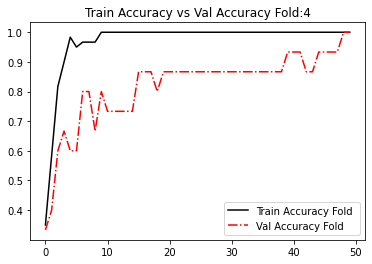

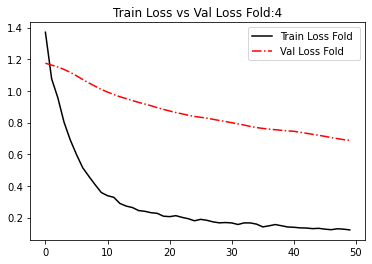

Val-Score for fold 4: loss of 0.6921980381011963; acc of 100.0%
Test-Score for fold 4: loss of 0.7950603365898132; acc of 73.33333492279053%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 847ms/step - loss: 1.3358 - acc: 0.3500 - val_loss: 1.1634 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 663ms/step - loss: 1.0652 - acc: 0.5333 - val_loss: 1.1424 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 739ms/step - loss: 0.9236 - acc: 0.7500 - val_loss: 1.1202 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 667ms/step - loss: 0.7841 - acc: 0.8833 - val_

2/2 [==============================] - 1s 672ms/step - loss: 0.1406 - acc: 1.0000 - val_loss: 0.5469 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 00041: early stopping


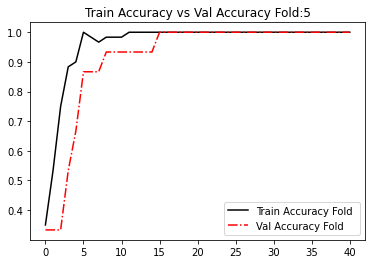

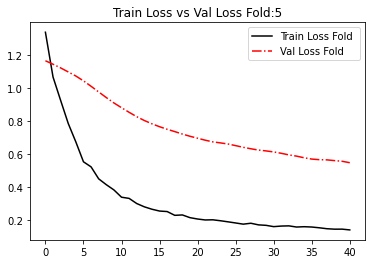

Val-Score for fold 5: loss of 0.7646045088768005; acc of 100.0%
Test-Score for fold 5: loss of 0.8613451719284058; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:100.0 +- 0.0
Test Accuracy:86.66666746139526 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 771ms/step - loss: 1.3287 - acc: 0.3667 - val_loss: 1.1778 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 657ms/step - loss: 1.1646 - acc: 0.4000 - val_loss: 1.1622 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 628ms/step - loss: 1.0017 - acc

2/2 [==============================] - 1s 700ms/step - loss: 0.1457 - acc: 1.0000 - val_loss: 0.6061 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 688ms/step - loss: 0.1446 - acc: 1.0000 - val_loss: 0.6014 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 1.00000
Epoch 00042: early stopping


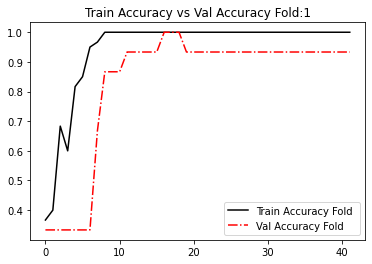

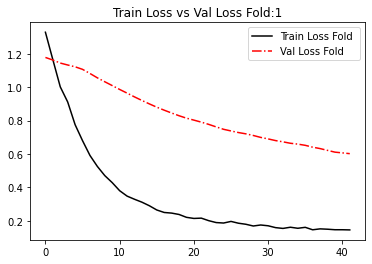

Val-Score for fold 1: loss of 0.8618484735488892; acc of 100.0%
Test-Score for fold 1: loss of 0.9118068218231201; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 764ms/step - loss: 1.2917 - acc: 0.4000 - val_loss: 1.1632 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 760ms/step - loss: 1.0881 - acc: 0.4500 - val_loss: 1.1345 - val_acc: 0.5333

Epoch 00002: val_acc did not improve from 0.66667
Epoch 3/50
2/2 [==============================] - 1s 752ms/step - loss: 0.9269 - acc: 0.8167 - val_loss: 1.1037 - val_acc: 0.8000

Epoch 00003: val_acc improved from 0.66667 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 4/50

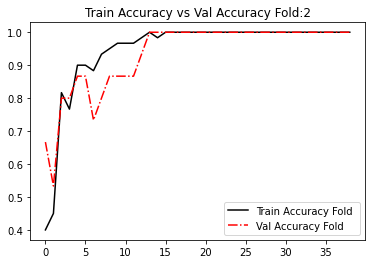

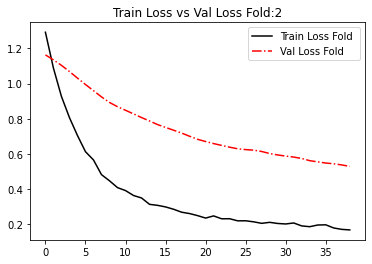

Val-Score for fold 2: loss of 0.7873188257217407; acc of 100.0%
Test-Score for fold 2: loss of 0.871308445930481; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 754ms/step - loss: 1.2485 - acc: 0.3167 - val_loss: 1.1745 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 656ms/step - loss: 1.1878 - acc: 0.3333 - val_loss: 1.1591 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 660ms/step - loss: 0.9697 - acc: 0.7333 - val_loss: 1.1442 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.40000 to 0.6

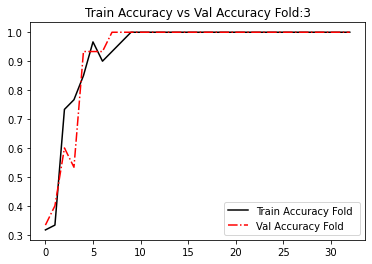

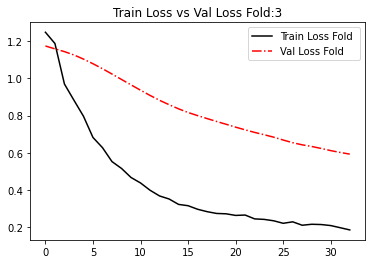

Val-Score for fold 3: loss of 1.0235377550125122; acc of 100.0%
Test-Score for fold 3: loss of 1.0665128231048584; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 745ms/step - loss: 1.3385 - acc: 0.3167 - val_loss: 1.1733 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 701ms/step - loss: 1.1140 - acc: 0.4000 - val_loss: 1.1628 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 662ms/step - loss: 0.9684 - acc: 0.7500 - val_loss: 1.1549 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.5333

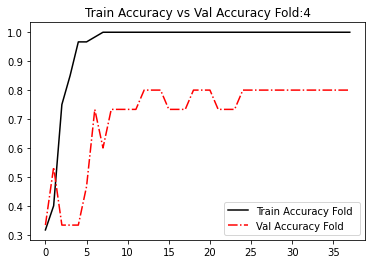

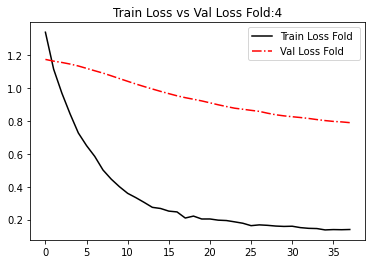

Val-Score for fold 4: loss of 1.0084742307662964; acc of 80.0000011920929%
Test-Score for fold 4: loss of 1.0023547410964966; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 781ms/step - loss: 1.3228 - acc: 0.4000 - val_loss: 1.1769 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 663ms/step - loss: 1.1568 - acc: 0.4333 - val_loss: 1.1624 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.40000
Epoch 3/50
2/2 [==============================] - 1s 643ms/step - loss: 0.9266 - acc: 0.7333 - val_loss: 1.1504 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.40000
Epoch 4/50
2/2 [==============================] - 1s 697ms/step - loss: 0.8744 - acc: 0.

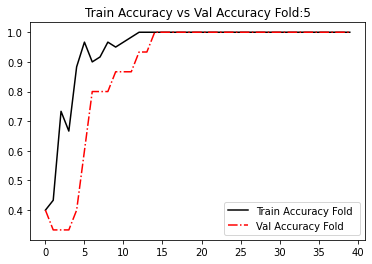

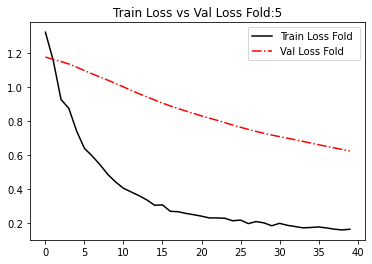

Val-Score for fold 5: loss of 0.9234750270843506; acc of 100.0%
Test-Score for fold 5: loss of 0.975951611995697; acc of 80.0000011920929%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:96.00000023841858 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 750ms/step - loss: 1.2318 - acc: 0.4000 - val_loss: 1.1627 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 702ms/step - loss: 1.0612 - acc: 0.5500 - val_loss: 1.1330 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.33333 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_che

2/2 [==============================] - 1s 640ms/step - loss: 0.1194 - acc: 1.0000 - val_loss: 0.5709 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 716ms/step - loss: 0.1123 - acc: 1.0000 - val_loss: 0.5663 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 711ms/step - loss: 0.1164 - acc: 1.0000 - val_loss: 0.5621 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 694ms/step - loss: 0.1116 - acc: 1.0000 - val_loss: 0.5591 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 664ms/step - loss: 0.1068 - acc: 1.0000 - val_loss: 0.5543 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 662ms/step - loss: 0.1096 - acc: 1.0000 - val_lo

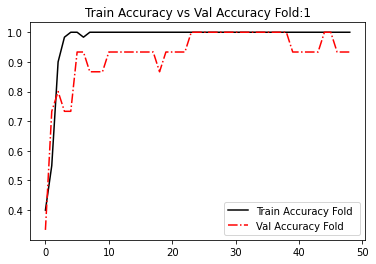

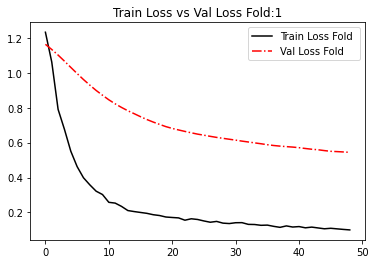

Val-Score for fold 1: loss of 0.6561168432235718; acc of 100.0%
Test-Score for fold 1: loss of 0.6005181670188904; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 837ms/step - loss: 1.4635 - acc: 0.2167 - val_loss: 1.1760 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 668ms/step - loss: 1.1306 - acc: 0.4000 - val_loss: 1.1560 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.33333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 701ms/step - loss: 0.9178 - acc: 0.7667 - val_loss: 1.1393 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.80000
Epoch 4/50

2/2 [==============================] - 1s 685ms/step - loss: 0.1322 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 737ms/step - loss: 0.1311 - acc: 1.0000 - val_loss: 0.4834 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 708ms/step - loss: 0.1256 - acc: 1.0000 - val_loss: 0.4759 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 704ms/step - loss: 0.1336 - acc: 1.0000 - val_loss: 0.4677 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 2s 835ms/step - loss: 0.1307 - acc: 1.0000 - val_loss: 0.4602 - val_acc: 1.0000

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
2/2 [==============================] - 1s 760ms/step - loss: 0.1260 - acc: 1.0000 - val_lo

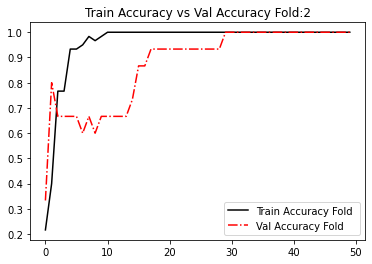

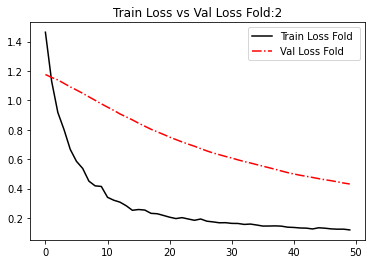

Val-Score for fold 2: loss of 0.6186271905899048; acc of 100.0%
Test-Score for fold 2: loss of 0.6270549893379211; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 832ms/step - loss: 1.2951 - acc: 0.3167 - val_loss: 1.1770 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 719ms/step - loss: 1.1016 - acc: 0.3833 - val_loss: 1.1625 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 734ms/step - loss: 0.9208 - acc: 0.9000 - val_loss: 1.1450 - val_acc: 0.4000

Epoch 00003: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\asset


Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
2/2 [==============================] - 1s 660ms/step - loss: 0.1280 - acc: 1.0000 - val_loss: 0.6138 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 635ms/step - loss: 0.1270 - acc: 1.0000 - val_loss: 0.6084 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 632ms/step - loss: 0.1231 - acc: 1.0000 - val_loss: 0.6060 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 641ms/step - loss: 0.1246 - acc: 1.0000 - val_loss: 0.6011 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 710ms/step - loss: 0.1210 - acc: 1.0000 - val_loss: 0.5957 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [======================

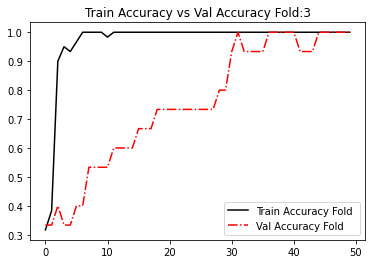

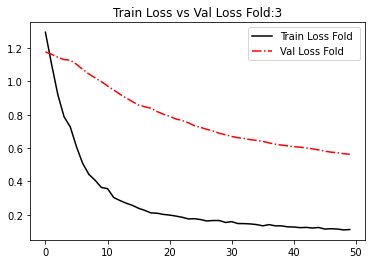

Val-Score for fold 3: loss of 0.6624923944473267; acc of 100.0%
Test-Score for fold 3: loss of 0.6822319030761719; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 756ms/step - loss: 1.2519 - acc: 0.4333 - val_loss: 1.1654 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 640ms/step - loss: 1.0274 - acc: 0.7000 - val_loss: 1.1447 - val_acc: 0.6000

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/50
2/2 [==============================] - 1s 676ms/step - loss: 0.8653 - acc: 0.9167 - val_loss: 1.1223 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50
2/2 [==============================] - 1s 624ms/step - loss: 0.7236 - acc: 0.9167 - val_

2/2 [==============================] - 1s 585ms/step - loss: 0.1321 - acc: 1.0000 - val_loss: 0.5358 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 615ms/step - loss: 0.1233 - acc: 1.0000 - val_loss: 0.5303 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 598ms/step - loss: 0.1297 - acc: 1.0000 - val_loss: 0.5254 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 634ms/step - loss: 0.1232 - acc: 1.0000 - val_loss: 0.5214 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 621ms/step - loss: 0.1206 - acc: 1.0000 - val_loss: 0.5141 - val_acc: 0.9333

Epoch 00046: val_acc did not improve from 0.93333
Epoch 47/50
2/2 [==============================] - 1s 661ms/step - loss: 0.1230 - acc: 1.0000 - val_lo

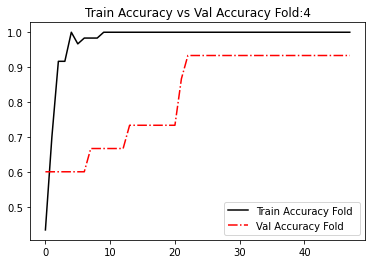

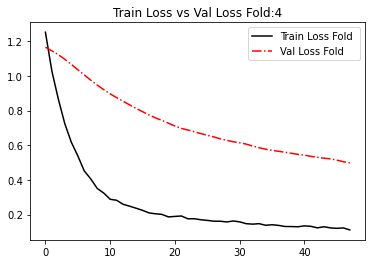

Val-Score for fold 4: loss of 0.6877188086509705; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.6172803044319153; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 753ms/step - loss: 1.2843 - acc: 0.3667 - val_loss: 1.1688 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 601ms/step - loss: 1.1114 - acc: 0.3500 - val_loss: 1.1444 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 625ms/step - loss: 0.8880 - acc: 0.8333 - val_loss: 1.1168 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0

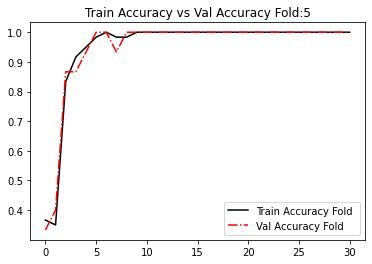

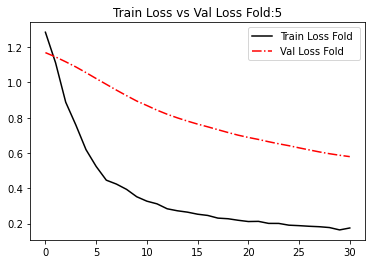

Val-Score for fold 5: loss of 1.0219817161560059; acc of 100.0%
Test-Score for fold 5: loss of 1.020912766456604; acc of 80.0000011920929%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:98.66666674613953 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 679ms/step - loss: 1.3865 - acc: 0.3333 - val_loss: 1.1692 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 624ms/step - loss: 1.0446 - acc: 0.5667 - val_loss: 1.1506 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.46667 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_che

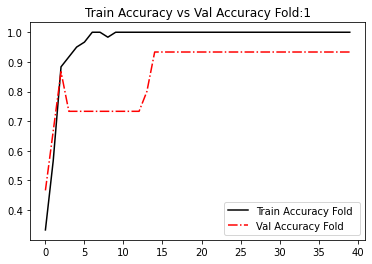

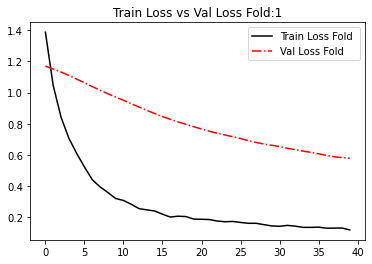

Val-Score for fold 1: loss of 0.8653836846351624; acc of 93.33333373069763%
Test-Score for fold 1: loss of 0.8300660252571106; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 725ms/step - loss: 1.1925 - acc: 0.4333 - val_loss: 1.1670 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 617ms/step - loss: 1.0304 - acc: 0.6667 - val_loss: 1.1478 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 646ms/step - loss: 0.8874 - acc: 0.8500 - val_loss: 1.1275 - val_acc: 0.5333

Epoch 00003: val_acc improved from 0

2/2 [==============================] - 1s 629ms/step - loss: 0.1371 - acc: 1.0000 - val_loss: 0.4842 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 688ms/step - loss: 0.1348 - acc: 1.0000 - val_loss: 0.4741 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 615ms/step - loss: 0.1273 - acc: 1.0000 - val_loss: 0.4637 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 665ms/step - loss: 0.1380 - acc: 1.0000 - val_loss: 0.4538 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 608ms/step - loss: 0.1333 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 604ms/step - loss: 0.1257 - acc: 1.0000 - val_lo

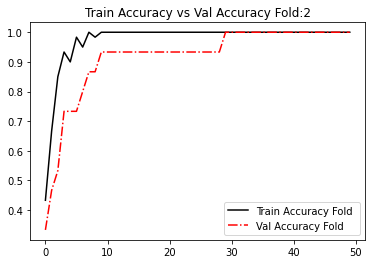

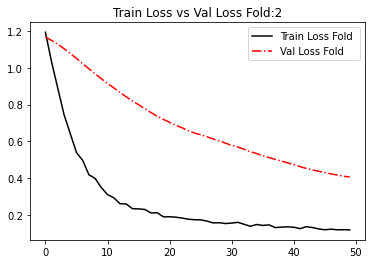

Val-Score for fold 2: loss of 0.5907614827156067; acc of 100.0%
Test-Score for fold 2: loss of 0.5555185079574585; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 697ms/step - loss: 1.2058 - acc: 0.3667 - val_loss: 1.1635 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 606ms/step - loss: 1.0813 - acc: 0.5667 - val_loss: 1.1406 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.46667 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 588ms/step - loss: 0.8577 - acc: 0.9667 - val_loss: 1.1144 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.60000 to 0.

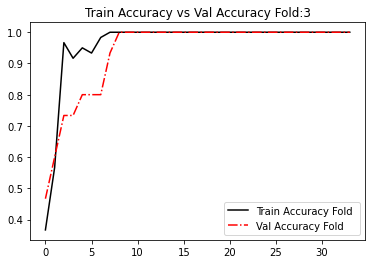

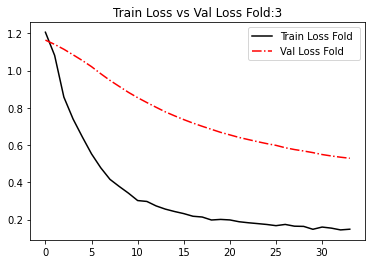

Val-Score for fold 3: loss of 0.9149860143661499; acc of 100.0%
Test-Score for fold 3: loss of 0.8976360559463501; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 960ms/step - loss: 1.5323 - acc: 0.3500 - val_loss: 1.1725 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 917ms/step - loss: 1.1640 - acc: 0.3333 - val_loss: 1.1630 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 2s 860ms/step - loss: 0.9284 - acc: 0.8167 - val_loss: 1.1523 - val_acc: 0.4000

Epoch 00003: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\asset

2/2 [==============================] - 1s 617ms/step - loss: 0.1353 - acc: 1.0000 - val_loss: 0.7115 - val_acc: 0.8667

Epoch 00041: val_acc improved from 0.80000 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 42/50
2/2 [==============================] - 1s 690ms/step - loss: 0.1309 - acc: 1.0000 - val_loss: 0.6976 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 593ms/step - loss: 0.1260 - acc: 1.0000 - val_loss: 0.6887 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 1s 642ms/step - loss: 0.1279 - acc: 1.0000 - val_loss: 0.6796 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.86667
Epoch 45/50
2/2 [==============================] - 1s 600ms/step - loss: 0.1248 - acc: 1.0000 - val_loss: 0.6684 - val_acc: 0.8667

Epoch 00045: val_acc did not improve from 0.86667
E

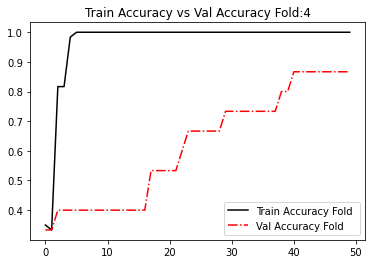

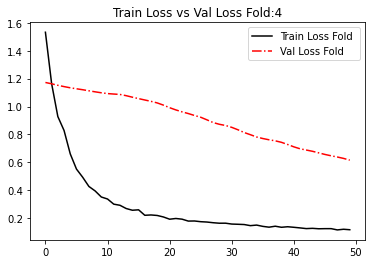

Val-Score for fold 4: loss of 0.711501955986023; acc of 86.66666746139526%
Test-Score for fold 4: loss of 0.6757283806800842; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 695ms/step - loss: 1.4090 - acc: 0.2500 - val_loss: 1.1694 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 622ms/step - loss: 1.1485 - acc: 0.4167 - val_loss: 1.1556 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.33333 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 640ms/step - loss: 1.0208 - acc: 0.6333 - val_loss: 1.1413 - val_acc: 0.6000

Epoch 00003: val_acc did not improve 

2/2 [==============================] - 1s 627ms/step - loss: 0.1295 - acc: 1.0000 - val_loss: 0.6485 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 579ms/step - loss: 0.1298 - acc: 1.0000 - val_loss: 0.6408 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 599ms/step - loss: 0.1316 - acc: 1.0000 - val_loss: 0.6336 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 614ms/step - loss: 0.1223 - acc: 1.0000 - val_loss: 0.6272 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 592ms/step - loss: 0.1236 - acc: 1.0000 - val_loss: 0.6203 - val_acc: 0.8667

Epoch 00046: val_acc did not improve from 0.93333
Epoch 47/50
2/2 [==============================] - 1s 575ms/step - loss: 0.1211 - acc: 1.0000 - val_lo

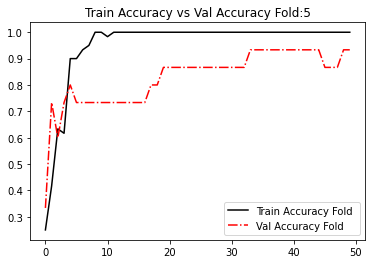

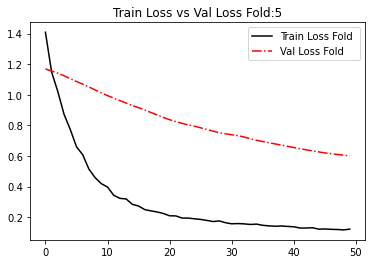

Val-Score for fold 5: loss of 0.7125799059867859; acc of 93.33333373069763%
Test-Score for fold 5: loss of 0.6349882483482361; acc of 100.0%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:94.6666669845581 +- 0.0
Test Accuracy:93.33333373069763 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 692ms/step - loss: 1.3137 - acc: 0.2833 - val_loss: 1.1654 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 614ms/step - loss: 1.0656 - acc: 0.4833 - val_loss: 1.1483 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.66667 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to

2/2 [==============================] - 1s 699ms/step - loss: 0.1337 - acc: 1.0000 - val_loss: 0.5463 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 00041: early stopping


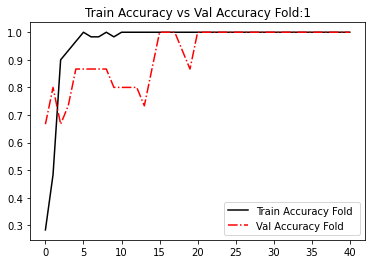

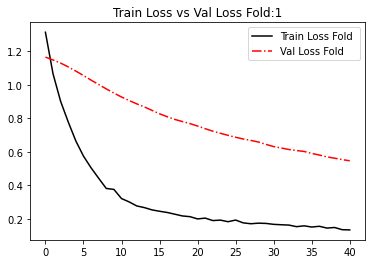

Val-Score for fold 1: loss of 0.8269384503364563; acc of 100.0%
Test-Score for fold 1: loss of 0.7747746706008911; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 825ms/step - loss: 1.2340 - acc: 0.2667 - val_loss: 1.1668 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 747ms/step - loss: 1.0871 - acc: 0.4500 - val_loss: 1.1465 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.40000 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 790ms/step - loss: 0.8862 - acc: 0.7833 - val_loss: 1.1210 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0.53333 to 0.

2/2 [==============================] - 1s 715ms/step - loss: 0.1490 - acc: 1.0000 - val_loss: 0.5222 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 762ms/step - loss: 0.1303 - acc: 1.0000 - val_loss: 0.5193 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 763ms/step - loss: 0.1360 - acc: 1.0000 - val_loss: 0.5101 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 745ms/step - loss: 0.1259 - acc: 1.0000 - val_loss: 0.5010 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 737ms/step - loss: 0.1366 - acc: 1.0000 - val_loss: 0.4976 - val_acc: 1.0000

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
2/2 [==============================] - 1s 732ms/step - loss: 0.1236 - acc: 1.0000 - val_lo

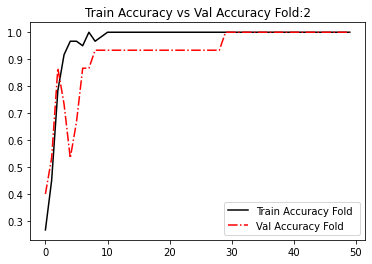

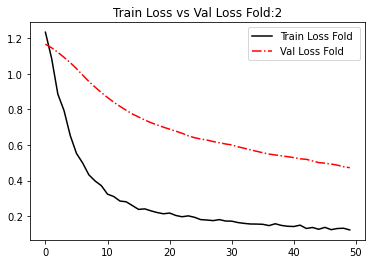

Val-Score for fold 2: loss of 0.6056010127067566; acc of 100.0%
Test-Score for fold 2: loss of 0.5899974703788757; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 847ms/step - loss: 1.2879 - acc: 0.3667 - val_loss: 1.1670 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 713ms/step - loss: 1.0936 - acc: 0.4833 - val_loss: 1.1447 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 725ms/step - loss: 0.9394 - acc: 0.9333 - val_loss: 1.1203 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50

2/2 [==============================] - 1s 596ms/step - loss: 0.1358 - acc: 1.0000 - val_loss: 0.4705 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 600ms/step - loss: 0.1404 - acc: 1.0000 - val_loss: 0.4686 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 574ms/step - loss: 0.1384 - acc: 1.0000 - val_loss: 0.4664 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 609ms/step - loss: 0.1350 - acc: 1.0000 - val_loss: 0.4652 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1341 - acc: 1.0000 - val_loss: 0.4568 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 669ms/step - loss: 0.1357 - acc: 1.0000 - val_lo

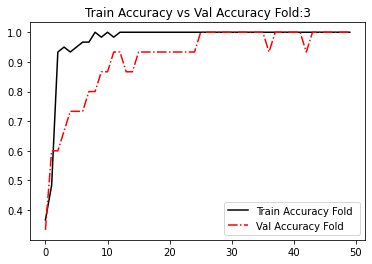

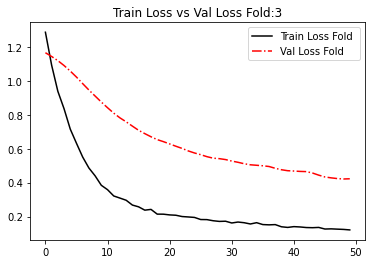

Val-Score for fold 3: loss of 0.565031111240387; acc of 100.0%
Test-Score for fold 3: loss of 0.5752980709075928; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 689ms/step - loss: 1.2735 - acc: 0.3333 - val_loss: 1.1674 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 594ms/step - loss: 1.0106 - acc: 0.7667 - val_loss: 1.1517 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.53333
Epoch 3/50
2/2 [==============================] - 1s 628ms/step - loss: 0.8727 - acc: 0.8667 - val_loss: 1.1355 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.53333
Epoch 4/50
2/2 [==============================] - 1s 605ms/step - loss: 0.7530 - acc: 0.9167 - val_l

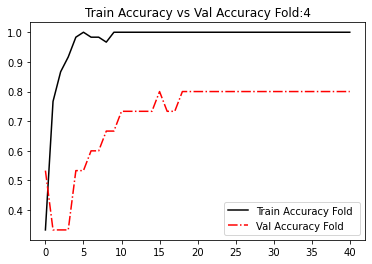

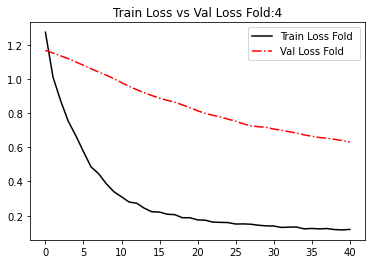

Val-Score for fold 4: loss of 0.8878050446510315; acc of 80.0000011920929%
Test-Score for fold 4: loss of 0.8269066214561462; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 695ms/step - loss: 1.4398 - acc: 0.2667 - val_loss: 1.1711 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 583ms/step - loss: 1.1204 - acc: 0.4667 - val_loss: 1.1554 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.46667 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 577ms/step - loss: 0.9567 - acc: 0.9167 - val_loss: 1.1384 - val_acc: 0.9333

Epoch 00003: val_acc improved from 0.8

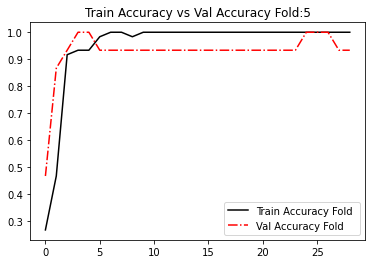

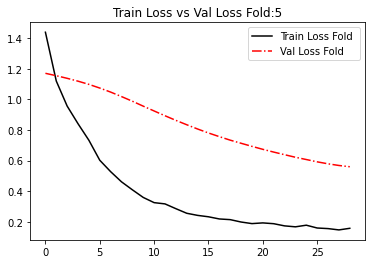

Val-Score for fold 5: loss of 1.1196420192718506; acc of 100.0%
Test-Score for fold 5: loss of 1.1202629804611206; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:96.00000023841858 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 698ms/step - loss: 1.3834 - acc: 0.2833 - val_loss: 1.1684 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 603ms/step - loss: 1.0897 - acc: 0.5667 - val_loss: 1.1425 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_c

2/2 [==============================] - 1s 610ms/step - loss: 0.1340 - acc: 1.0000 - val_loss: 0.5828 - val_acc: 0.9333

Epoch 00040: val_acc did not improve from 0.93333
Epoch 41/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1361 - acc: 1.0000 - val_loss: 0.5800 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 610ms/step - loss: 0.1243 - acc: 1.0000 - val_loss: 0.5721 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 636ms/step - loss: 0.1218 - acc: 1.0000 - val_loss: 0.5638 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 613ms/step - loss: 0.1222 - acc: 1.0000 - val_loss: 0.5550 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 594ms/step - loss: 0.1250 - acc: 1.0000 - val_lo

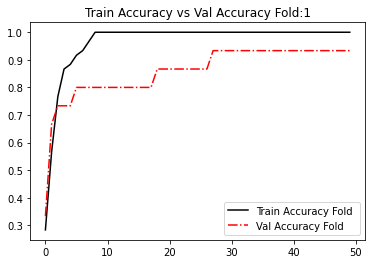

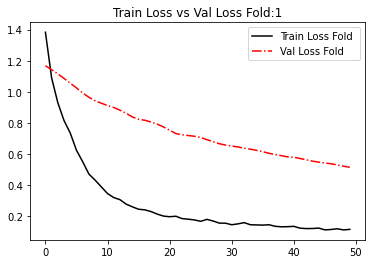

Val-Score for fold 1: loss of 0.680141031742096; acc of 93.33333373069763%
Test-Score for fold 1: loss of 0.6010105609893799; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 698ms/step - loss: 1.4293 - acc: 0.2833 - val_loss: 1.1694 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 609ms/step - loss: 1.1437 - acc: 0.4500 - val_loss: 1.1543 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 584ms/step - loss: 0.9533 - acc: 0.8000 - val_loss: 1.1462 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.60000

2/2 [==============================] - 1s 598ms/step - loss: 0.1511 - acc: 1.0000 - val_loss: 0.6047 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 583ms/step - loss: 0.1498 - acc: 1.0000 - val_loss: 0.5985 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 1s 639ms/step - loss: 0.1549 - acc: 1.0000 - val_loss: 0.5892 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.86667
Epoch 45/50
2/2 [==============================] - 1s 668ms/step - loss: 0.1436 - acc: 1.0000 - val_loss: 0.5799 - val_acc: 0.8667

Epoch 00045: val_acc did not improve from 0.86667
Epoch 00045: early stopping


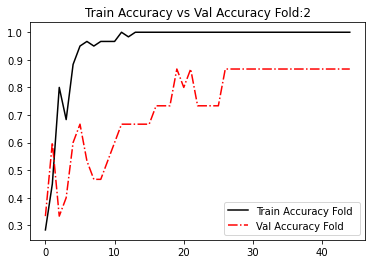

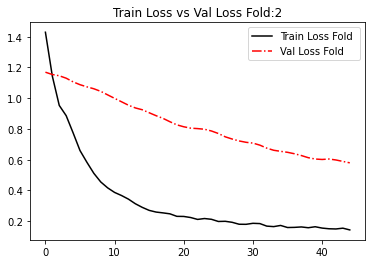

Val-Score for fold 2: loss of 0.8269219994544983; acc of 86.66666746139526%
Test-Score for fold 2: loss of 0.8387995958328247; acc of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 725ms/step - loss: 1.4291 - acc: 0.4000 - val_loss: 1.1683 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 607ms/step - loss: 1.0822 - acc: 0.4500 - val_loss: 1.1432 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/50
2/2 [==============================] - 1s 631ms/step - loss: 0.8668 - acc: 0.8500 - val_loss: 1.1234 - val_acc: 0.4000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50
2/2 [==============================] - 1s 624ms/step - loss: 0.7236 - acc: 0

2/2 [==============================] - 1s 611ms/step - loss: 0.1259 - acc: 1.0000 - val_loss: 0.5160 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 643ms/step - loss: 0.1297 - acc: 1.0000 - val_loss: 0.5086 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 593ms/step - loss: 0.1285 - acc: 1.0000 - val_loss: 0.5051 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 608ms/step - loss: 0.1213 - acc: 1.0000 - val_loss: 0.5029 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 622ms/step - loss: 0.1227 - acc: 1.0000 - val_loss: 0.4984 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 637ms/step - loss: 0.1186 - acc: 1.0000 - val_lo

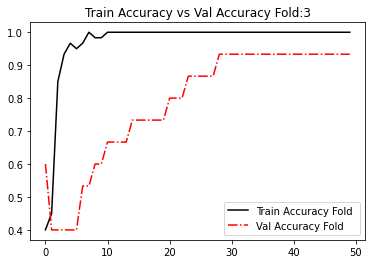

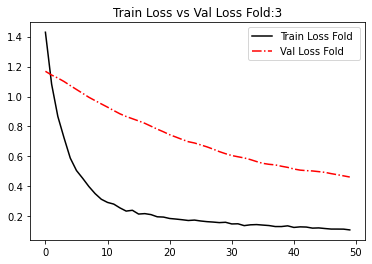

Val-Score for fold 3: loss of 0.6320719122886658; acc of 93.33333373069763%
Test-Score for fold 3: loss of 0.6143964529037476; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 729ms/step - loss: 1.1855 - acc: 0.4167 - val_loss: 1.1731 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 599ms/step - loss: 1.0912 - acc: 0.5667 - val_loss: 1.1593 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 622ms/step - loss: 0.9661 - acc: 0.7167 - val_loss: 1.1457 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_chec


Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 600ms/step - loss: 0.1421 - acc: 1.0000 - val_loss: 0.6102 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 597ms/step - loss: 0.1329 - acc: 1.0000 - val_loss: 0.5982 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 00042: early stopping


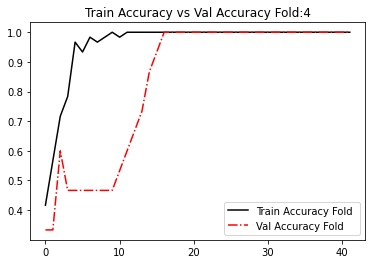

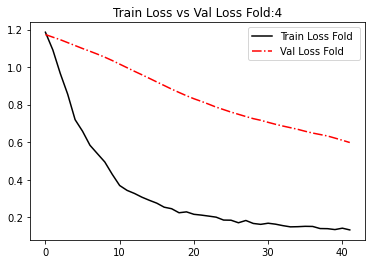

Val-Score for fold 4: loss of 0.9017835259437561; acc of 100.0%
Test-Score for fold 4: loss of 0.8985260128974915; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 758ms/step - loss: 1.3162 - acc: 0.3667 - val_loss: 1.1649 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 626ms/step - loss: 1.0662 - acc: 0.5000 - val_loss: 1.1492 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 612ms/step - loss: 0.9486 - acc: 0.7667 - val_loss: 1.1318 - val_acc: 0.9333

Epoch 00003: val_acc improved from 0.60000 to 0.9

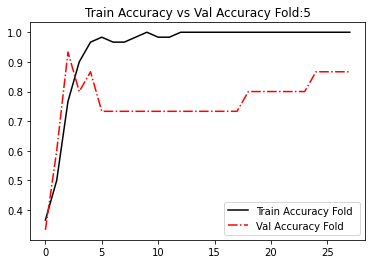

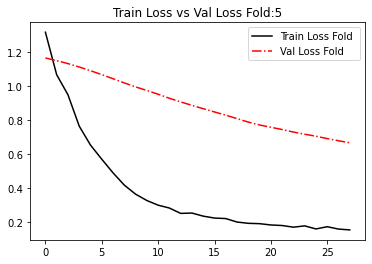

Val-Score for fold 5: loss of 1.1318179368972778; acc of 93.33333373069763%
Test-Score for fold 5: loss of 1.1256160736083984; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:93.33333373069763 +- 0.0
Test Accuracy:80.0000011920929 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 717ms/step - loss: 1.3782 - acc: 0.3833 - val_loss: 1.1593 - val_acc: 0.7333

Epoch 00001: val_acc improved from -inf to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 581ms/step - loss: 1.0525 - acc: 0.7667 - val_loss: 1.1305 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.73333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Asset


Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 584ms/step - loss: 0.1171 - acc: 1.0000 - val_loss: 0.3817 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 622ms/step - loss: 0.1182 - acc: 1.0000 - val_loss: 0.3742 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 692ms/step - loss: 0.1144 - acc: 1.0000 - val_loss: 0.3676 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 575ms/step - loss: 0.1153 - acc: 1.0000 - val_loss: 0.3608 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 626ms/step - loss: 0.1126 - acc: 1.0000 - val_loss: 0.3547 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [======================

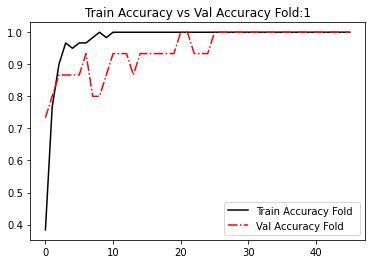

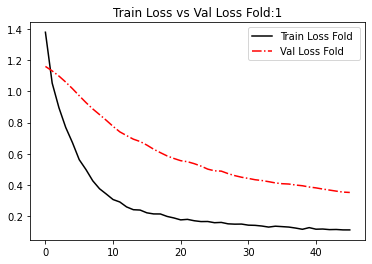

Val-Score for fold 1: loss of 0.5557519793510437; acc of 100.0%
Test-Score for fold 1: loss of 0.6244839429855347; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 700ms/step - loss: 1.3925 - acc: 0.3500 - val_loss: 1.1697 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 569ms/step - loss: 1.0980 - acc: 0.5333 - val_loss: 1.1559 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 598ms/step - loss: 0.9157 - acc: 0.8333 - val_loss: 1.1375 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 596ms/step - loss: 0.8022 - acc: 0.8667 - val_


Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
2/2 [==============================] - 1s 600ms/step - loss: 0.1409 - acc: 1.0000 - val_loss: 0.4895 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1381 - acc: 1.0000 - val_loss: 0.4797 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 581ms/step - loss: 0.1319 - acc: 1.0000 - val_loss: 0.4684 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 588ms/step - loss: 0.1344 - acc: 1.0000 - val_loss: 0.4571 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1371 - acc: 1.0000 - val_loss: 0.4483 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [======================

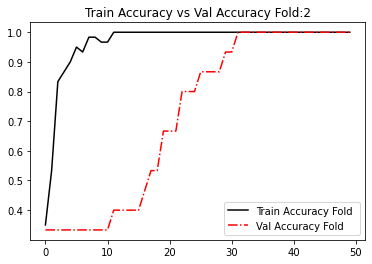

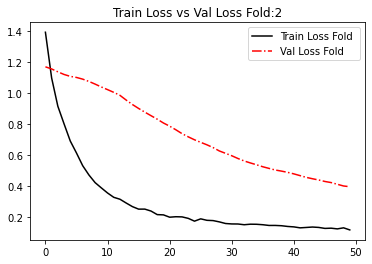

Val-Score for fold 2: loss of 0.578704297542572; acc of 100.0%
Test-Score for fold 2: loss of 0.6230233311653137; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 773ms/step - loss: 1.2287 - acc: 0.3667 - val_loss: 1.1576 - val_acc: 0.7333

Epoch 00001: val_acc improved from -inf to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 581ms/step - loss: 1.0204 - acc: 0.6333 - val_loss: 1.1270 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.73333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 601ms/step - loss: 0.8513 - acc: 0.8667 - val_loss: 1.0954 - val_acc: 0.8000

Epoch 00003: val_acc did not improve from 0.80000

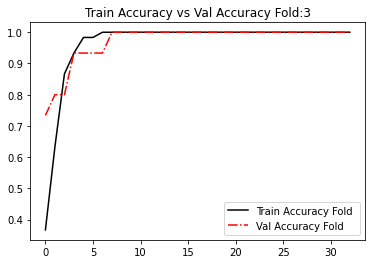

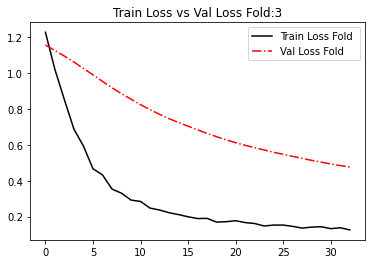

Val-Score for fold 3: loss of 0.9190172553062439; acc of 100.0%
Test-Score for fold 3: loss of 0.9860483407974243; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 712ms/step - loss: 1.2490 - acc: 0.3167 - val_loss: 1.1688 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 580ms/step - loss: 1.1147 - acc: 0.4667 - val_loss: 1.1552 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 591ms/step - loss: 0.8922 - acc: 0.8500 - val_loss: 1.1495 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 597ms/step - loss: 0.7556 - acc: 0.9000 - val_

2/2 [==============================] - 1s 609ms/step - loss: 0.1379 - acc: 1.0000 - val_loss: 0.6585 - val_acc: 0.7333

Epoch 00041: val_acc did not improve from 0.80000
Epoch 42/50
2/2 [==============================] - 1s 677ms/step - loss: 0.1318 - acc: 1.0000 - val_loss: 0.6514 - val_acc: 0.7333

Epoch 00042: val_acc did not improve from 0.80000
Epoch 43/50
2/2 [==============================] - 1s 590ms/step - loss: 0.1346 - acc: 1.0000 - val_loss: 0.6435 - val_acc: 0.7333

Epoch 00043: val_acc did not improve from 0.80000
Epoch 44/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1329 - acc: 1.0000 - val_loss: 0.6304 - val_acc: 0.7333

Epoch 00044: val_acc did not improve from 0.80000
Epoch 45/50
2/2 [==============================] - 1s 619ms/step - loss: 0.1331 - acc: 1.0000 - val_loss: 0.6208 - val_acc: 0.8000

Epoch 00045: val_acc did not improve from 0.80000
Epoch 46/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1308 - acc: 1.0000 - val_lo

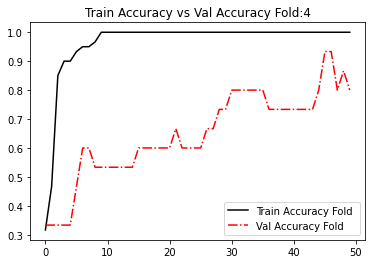

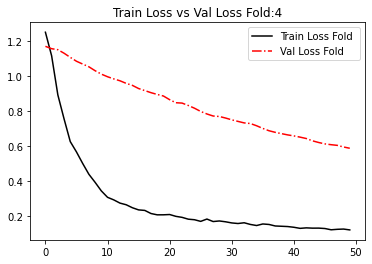

Val-Score for fold 4: loss of 0.6128892302513123; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.5922431945800781; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 755ms/step - loss: 1.4560 - acc: 0.3000 - val_loss: 1.1750 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 578ms/step - loss: 1.2318 - acc: 0.3833 - val_loss: 1.1635 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 620ms/step - loss: 1.0315 - acc: 0.6333 - val_loss: 1.1570 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 597ms/step - loss: 0.9809 - acc: 0.

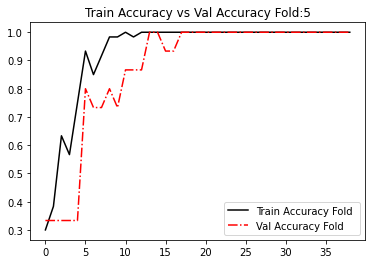

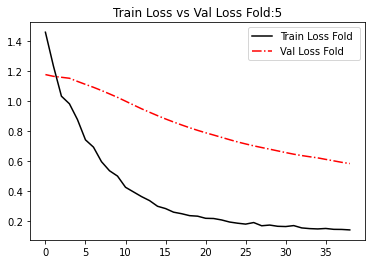

Val-Score for fold 5: loss of 0.9250161051750183; acc of 100.0%
Test-Score for fold 5: loss of 0.9607881903648376; acc of 73.33333492279053%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:98.66666674613953 +- 0.0
Test Accuracy:93.33333373069763 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 678ms/step - loss: 1.4225 - acc: 0.2333 - val_loss: 1.1691 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 593ms/step - loss: 1.0947 - acc: 0.4333 - val_loss: 1.1517 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.33333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written t

Epoch 41/50
2/2 [==============================] - 1s 607ms/step - loss: 0.1501 - acc: 1.0000 - val_loss: 0.5482 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 607ms/step - loss: 0.1505 - acc: 1.0000 - val_loss: 0.5395 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 627ms/step - loss: 0.1453 - acc: 1.0000 - val_loss: 0.5279 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 574ms/step - loss: 0.1455 - acc: 1.0000 - val_loss: 0.5166 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 623ms/step - loss: 0.1430 - acc: 1.0000 - val_loss: 0.5049 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 613ms/step - loss: 0.1467 - acc: 1.0

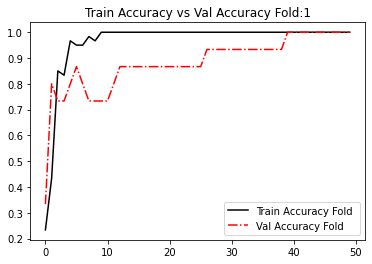

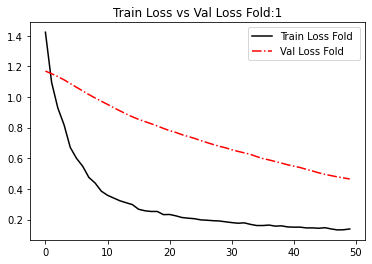

Val-Score for fold 1: loss of 0.5572785139083862; acc of 100.0%
Test-Score for fold 1: loss of 0.6120585799217224; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 716ms/step - loss: 1.2941 - acc: 0.3333 - val_loss: 1.1783 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 586ms/step - loss: 1.1347 - acc: 0.4000 - val_loss: 1.1658 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.33333 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 606ms/step - loss: 0.9508 - acc: 0.7667 - val_loss: 1.1541 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.73333
Epoch 4/50


Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 601ms/step - loss: 0.1283 - acc: 1.0000 - val_loss: 0.5912 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1226 - acc: 1.0000 - val_loss: 0.5857 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.86667
Epoch 45/50
2/2 [==============================] - 1s 596ms/step - loss: 0.1211 - acc: 1.0000 - val_loss: 0.5793 - val_acc: 0.8667

Epoch 00045: val_acc did not improve from 0.86667
Epoch 46/50
2/2 [==============================] - 1s 608ms/step - loss: 0.1166 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.8667

Epoch 00046: val_acc did not improve from 0.86667
Epoch 47/50
2/2 [==============================] - 1s 632ms/step - loss: 0.1178 - acc: 1.0000 - val_loss: 0.5641 - val_acc: 0.8667

Epoch 00047: val_acc did not improve from 0.86667
Epoch 48/50
2/2 [======================

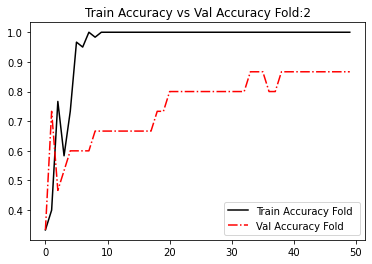

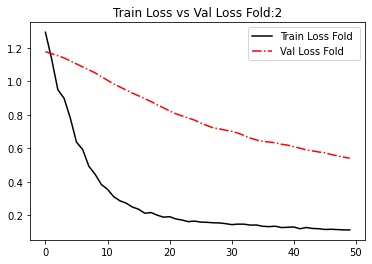

Val-Score for fold 2: loss of 0.6618562340736389; acc of 86.66666746139526%
Test-Score for fold 2: loss of 0.6617052555084229; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 691ms/step - loss: 1.2836 - acc: 0.3333 - val_loss: 1.1748 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 585ms/step - loss: 1.1272 - acc: 0.4333 - val_loss: 1.1563 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 603ms/step - loss: 0.9533 - acc: 0.7833 - val_loss: 1.1366 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.

2/2 [==============================] - 1s 671ms/step - loss: 0.1441 - acc: 1.0000 - val_loss: 0.4479 - val_acc: 1.0000

Epoch 00040: val_acc improved from 0.93333 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 41/50
2/2 [==============================] - 1s 678ms/step - loss: 0.1351 - acc: 1.0000 - val_loss: 0.4374 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 670ms/step - loss: 0.1314 - acc: 1.0000 - val_loss: 0.4297 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 706ms/step - loss: 0.1352 - acc: 1.0000 - val_loss: 0.4282 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 703ms/step - loss: 0.1322 - acc: 1.0000 - val_loss: 0.4233 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
E

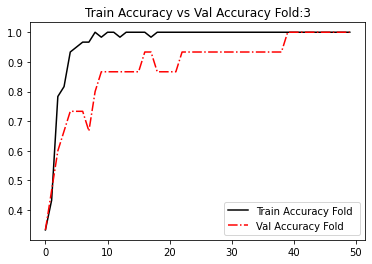

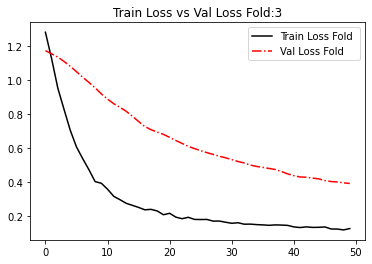

Val-Score for fold 3: loss of 0.4478934109210968; acc of 100.0%
Test-Score for fold 3: loss of 0.5233991146087646; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 744ms/step - loss: 1.1771 - acc: 0.3167 - val_loss: 1.1697 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 624ms/step - loss: 1.0993 - acc: 0.4667 - val_loss: 1.1552 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.46667 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 580ms/step - loss: 1.0081 - acc: 0.7167 - val_loss: 1.1408 - val_acc: 0.4000

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50

2/2 [==============================] - 2s 834ms/step - loss: 0.1278 - acc: 1.0000 - val_loss: 0.3803 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 00041: early stopping


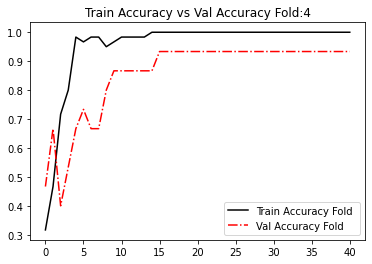

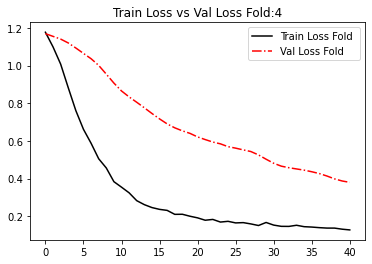

Val-Score for fold 4: loss of 0.7170875668525696; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.7888427376747131; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 718ms/step - loss: 1.2725 - acc: 0.2833 - val_loss: 1.1670 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 582ms/step - loss: 1.0515 - acc: 0.5667 - val_loss: 1.1453 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 582ms/step - loss: 0.8756 - acc: 0.9000 - val_loss: 1.1197 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0

2/2 [==============================] - 1s 589ms/step - loss: 0.1222 - acc: 1.0000 - val_loss: 0.5531 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 658ms/step - loss: 0.1219 - acc: 1.0000 - val_loss: 0.5499 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 626ms/step - loss: 0.1189 - acc: 1.0000 - val_loss: 0.5451 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 601ms/step - loss: 0.1154 - acc: 1.0000 - val_loss: 0.5432 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 599ms/step - loss: 0.1225 - acc: 1.0000 - val_loss: 0.5330 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 587ms/step - loss: 0.1184 - acc: 1.0000 - val_lo

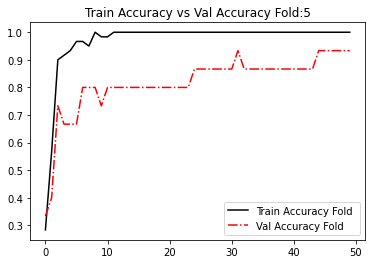

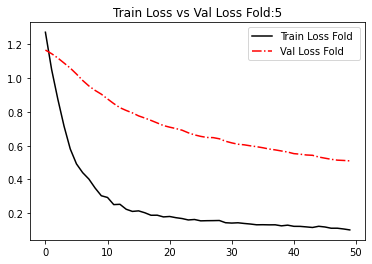

Val-Score for fold 5: loss of 0.6087893843650818; acc of 93.33333373069763%
Test-Score for fold 5: loss of 0.6453526616096497; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:94.6666669845581 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 831ms/step - loss: 1.4748 - acc: 0.2000 - val_loss: 1.1719 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 580ms/step - loss: 1.1701 - acc: 0.3667 - val_loss: 1.1586 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.40000 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to

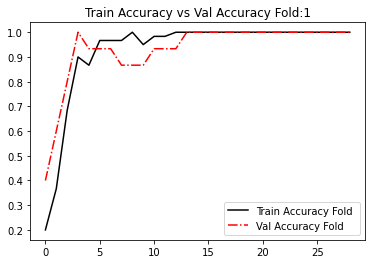

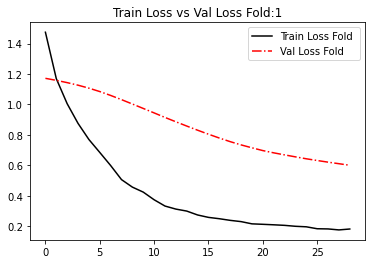

Val-Score for fold 1: loss of 1.1268327236175537; acc of 100.0%
Test-Score for fold 1: loss of 1.1270296573638916; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 776ms/step - loss: 1.4089 - acc: 0.2333 - val_loss: 1.1666 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 592ms/step - loss: 1.1168 - acc: 0.4833 - val_loss: 1.1318 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.33333 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 626ms/step - loss: 0.9375 - acc: 0.8167 - val_loss: 1.0932 - val_acc: 0.8667

Epoch 00003: val_acc did not improve from 0.86667
Epoch 4/50

2/2 [==============================] - 1s 605ms/step - loss: 0.1464 - acc: 1.0000 - val_loss: 0.4470 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 00043: early stopping


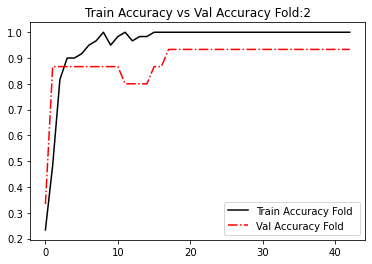

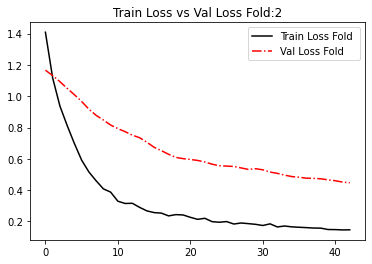

Val-Score for fold 2: loss of 0.628981351852417; acc of 93.33333373069763%
Test-Score for fold 2: loss of 0.47902506589889526; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 680ms/step - loss: 1.3690 - acc: 0.2833 - val_loss: 1.1703 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 583ms/step - loss: 1.0954 - acc: 0.5500 - val_loss: 1.1480 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.53333 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 593ms/step - loss: 0.8910 - acc: 0.8500 - val_loss: 1.1229 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.7333

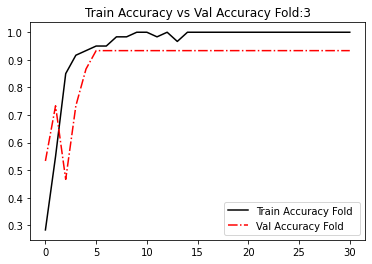

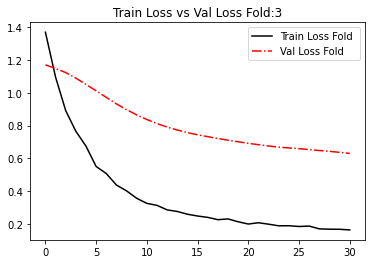

Val-Score for fold 3: loss of 1.0115840435028076; acc of 93.33333373069763%
Test-Score for fold 3: loss of 0.9858006834983826; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 690ms/step - loss: 1.4467 - acc: 0.3167 - val_loss: 1.1796 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 601ms/step - loss: 1.2629 - acc: 0.3667 - val_loss: 1.1817 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 582ms/step - loss: 1.0160 - acc: 0.5833 - val_loss: 1.1591 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 593ms/step - loss: 0.8927 - acc: 0

2/2 [==============================] - 1s 614ms/step - loss: 0.1597 - acc: 1.0000 - val_loss: 0.6576 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.86667
Epoch 41/50
2/2 [==============================] - 1s 613ms/step - loss: 0.1531 - acc: 1.0000 - val_loss: 0.6415 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.86667
Epoch 42/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1513 - acc: 1.0000 - val_loss: 0.6215 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 625ms/step - loss: 0.1496 - acc: 1.0000 - val_loss: 0.6030 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 1s 596ms/step - loss: 0.1418 - acc: 1.0000 - val_loss: 0.5920 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.86667
Epoch 45/50
2/2 [==============================] - 1s 670ms/step - loss: 0.1502 - acc: 1.0000 - val_lo

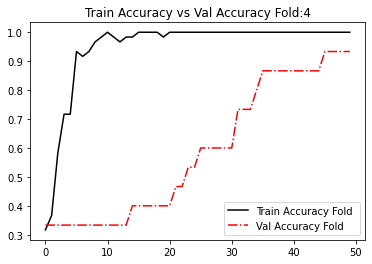

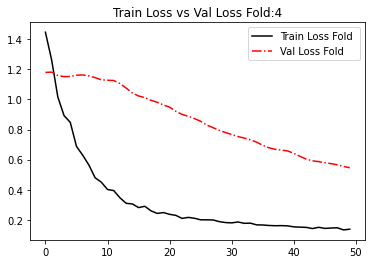

Val-Score for fold 4: loss of 0.5790039300918579; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.35523101687431335; acc of 100.0%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 688ms/step - loss: 1.2394 - acc: 0.3667 - val_loss: 1.1734 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 581ms/step - loss: 1.1462 - acc: 0.4000 - val_loss: 1.1626 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.60000 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 608ms/step - loss: 0.9911 - acc: 0.7333 - val_loss: 1.1503 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.66667 to 0

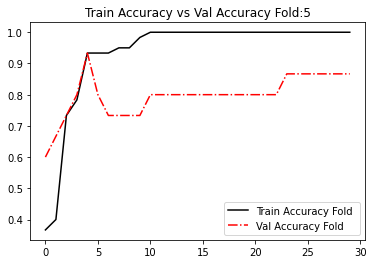

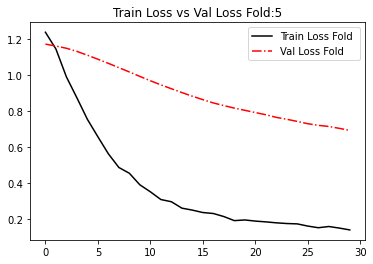

Val-Score for fold 5: loss of 1.1116925477981567; acc of 93.33333373069763%
Test-Score for fold 5: loss of 1.0831246376037598; acc of 100.0%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:94.6666669845581 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 680ms/step - loss: 1.3380 - acc: 0.2667 - val_loss: 1.1644 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 682ms/step - loss: 1.0456 - acc: 0.5333 - val_loss: 1.1443 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 587ms/step - loss: 0.9129 - acc:


Epoch 00038: val_acc did not improve from 0.93333
Epoch 39/50
2/2 [==============================] - 1s 598ms/step - loss: 0.1270 - acc: 1.0000 - val_loss: 0.5363 - val_acc: 0.9333

Epoch 00039: val_acc did not improve from 0.93333
Epoch 40/50
2/2 [==============================] - 1s 613ms/step - loss: 0.1283 - acc: 1.0000 - val_loss: 0.5292 - val_acc: 0.9333

Epoch 00040: val_acc did not improve from 0.93333
Epoch 41/50
2/2 [==============================] - 1s 589ms/step - loss: 0.1372 - acc: 1.0000 - val_loss: 0.5233 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 580ms/step - loss: 0.1285 - acc: 1.0000 - val_loss: 0.5177 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 577ms/step - loss: 0.1238 - acc: 1.0000 - val_loss: 0.5121 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [======================

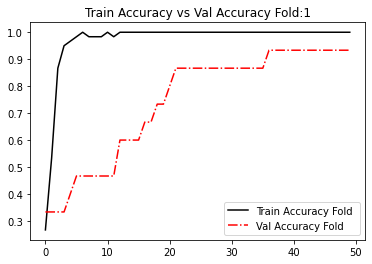

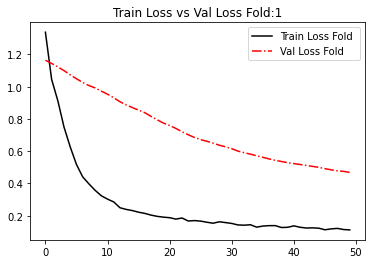

Val-Score for fold 1: loss of 0.5523419976234436; acc of 93.33333373069763%
Test-Score for fold 1: loss of 0.5672082304954529; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 738ms/step - loss: 1.4204 - acc: 0.3333 - val_loss: 1.1698 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 617ms/step - loss: 1.1065 - acc: 0.5333 - val_loss: 1.1546 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 599ms/step - loss: 0.9056 - acc: 0.8833 - val_loss: 1.1439 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 616ms/step - loss: 0.8003 - acc: 0

2/2 [==============================] - 1s 585ms/step - loss: 0.1559 - acc: 1.0000 - val_loss: 0.6407 - val_acc: 0.8000

Epoch 00040: val_acc did not improve from 0.80000
Epoch 41/50
2/2 [==============================] - 1s 585ms/step - loss: 0.1432 - acc: 1.0000 - val_loss: 0.6306 - val_acc: 0.8000

Epoch 00041: val_acc did not improve from 0.80000
Epoch 42/50
2/2 [==============================] - 1s 590ms/step - loss: 0.1484 - acc: 1.0000 - val_loss: 0.6102 - val_acc: 0.8000

Epoch 00042: val_acc did not improve from 0.80000
Epoch 43/50
2/2 [==============================] - 1s 584ms/step - loss: 0.1400 - acc: 1.0000 - val_loss: 0.5871 - val_acc: 0.8000

Epoch 00043: val_acc did not improve from 0.80000
Epoch 44/50
2/2 [==============================] - 1s 593ms/step - loss: 0.1459 - acc: 1.0000 - val_loss: 0.5764 - val_acc: 0.8000

Epoch 00044: val_acc did not improve from 0.80000
Epoch 45/50
2/2 [==============================] - 1s 596ms/step - loss: 0.1475 - acc: 1.0000 - val_lo

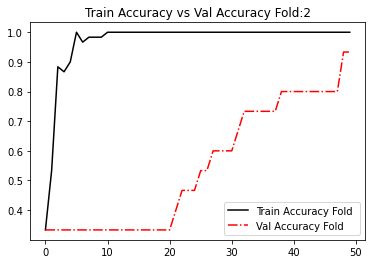

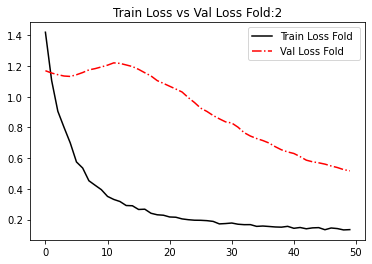

Val-Score for fold 2: loss of 0.525547206401825; acc of 93.33333373069763%
Test-Score for fold 2: loss of 0.5241347551345825; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 681ms/step - loss: 1.1726 - acc: 0.4500 - val_loss: 1.1708 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 591ms/step - loss: 1.0355 - acc: 0.6333 - val_loss: 1.1527 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.60000 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 591ms/step - loss: 0.8021 - acc: 0.9333 - val_loss: 1.1313 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.

2/2 [==============================] - 1s 674ms/step - loss: 0.1056 - acc: 1.0000 - val_loss: 0.6263 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 594ms/step - loss: 0.1007 - acc: 1.0000 - val_loss: 0.6164 - val_acc: 0.9333

Epoch 00043: val_acc improved from 0.86667 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 44/50
2/2 [==============================] - 1s 582ms/step - loss: 0.1002 - acc: 1.0000 - val_loss: 0.6103 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 626ms/step - loss: 0.1024 - acc: 1.0000 - val_loss: 0.6051 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 601ms/step - loss: 0.1017 - acc: 1.0000 - val_loss: 0.6015 - val_acc: 0.8667

Epoch 00046: val_acc did not improve from 0.93333
E

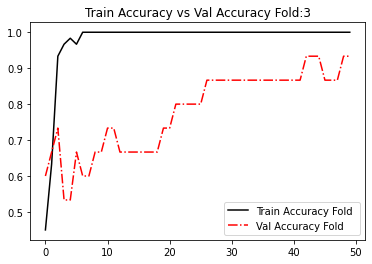

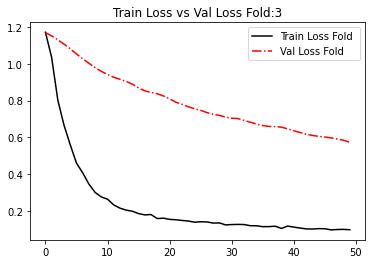

Val-Score for fold 3: loss of 0.6164358258247375; acc of 93.33333373069763%
Test-Score for fold 3: loss of 0.5166559219360352; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 717ms/step - loss: 1.4595 - acc: 0.2833 - val_loss: 1.1629 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 582ms/step - loss: 1.0952 - acc: 0.4167 - val_loss: 1.1378 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 602ms/step - loss: 0.8931 - acc: 0.8333 - val_loss: 1.1160 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.4000


Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
2/2 [==============================] - 1s 583ms/step - loss: 0.1272 - acc: 1.0000 - val_loss: 0.3842 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1265 - acc: 1.0000 - val_loss: 0.3783 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 601ms/step - loss: 0.1358 - acc: 1.0000 - val_loss: 0.3761 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 611ms/step - loss: 0.1229 - acc: 1.0000 - val_loss: 0.3725 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 600ms/step - loss: 0.1232 - acc: 1.0000 - val_loss: 0.3661 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [======================

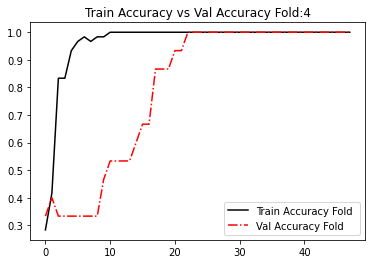

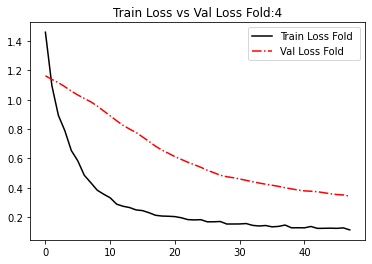

Val-Score for fold 4: loss of 0.5733635425567627; acc of 100.0%
Test-Score for fold 4: loss of 0.7144133448600769; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 741ms/step - loss: 1.3945 - acc: 0.2333 - val_loss: 1.1872 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 630ms/step - loss: 1.1615 - acc: 0.4833 - val_loss: 1.1789 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 689ms/step - loss: 0.9272 - acc: 0.8167 - val_loss: 1.1739 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 671ms/step - loss: 0.8554 - acc: 0.7167 - val_

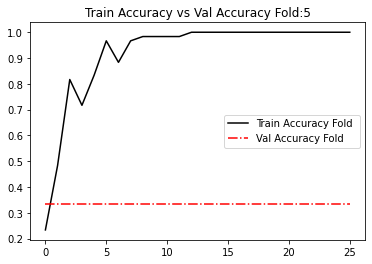

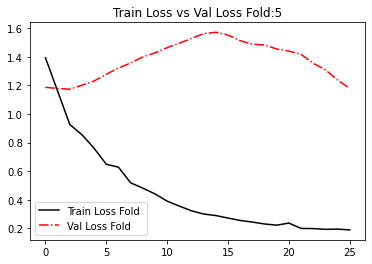

Val-Score for fold 5: loss of 1.187156319618225; acc of 33.33333432674408%
Test-Score for fold 5: loss of 1.1896065473556519; acc of 33.33333432674408%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:82.6666671037674 +- 0.0
Test Accuracy:86.66666746139526 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 857ms/step - loss: 1.3300 - acc: 0.3333 - val_loss: 1.1624 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 634ms/step - loss: 1.0807 - acc: 0.5000 - val_loss: 1.1367 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 712ms/ste

2/2 [==============================] - 1s 614ms/step - loss: 0.1423 - acc: 1.0000 - val_loss: 0.5702 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.86667
Epoch 41/50
2/2 [==============================] - 1s 594ms/step - loss: 0.1369 - acc: 1.0000 - val_loss: 0.5551 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.86667
Epoch 42/50
2/2 [==============================] - 1s 604ms/step - loss: 0.1361 - acc: 1.0000 - val_loss: 0.5297 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 596ms/step - loss: 0.1406 - acc: 1.0000 - val_loss: 0.5088 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 1s 604ms/step - loss: 0.1314 - acc: 1.0000 - val_loss: 0.5014 - val_acc: 0.9333

Epoch 00044: val_acc improved from 0.86667 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
E

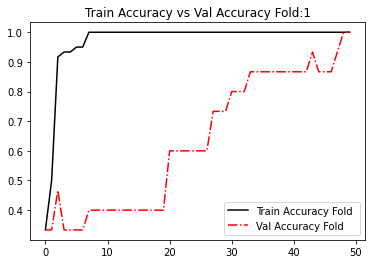

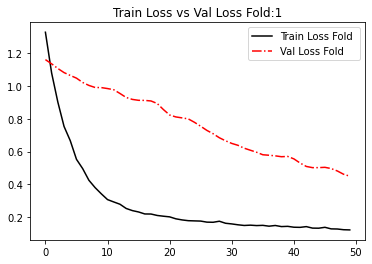

Val-Score for fold 1: loss of 0.46106797456741333; acc of 100.0%
Test-Score for fold 1: loss of 0.5268260836601257; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 745ms/step - loss: 1.4618 - acc: 0.3167 - val_loss: 1.1745 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 602ms/step - loss: 1.1203 - acc: 0.4167 - val_loss: 1.1602 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 598ms/step - loss: 0.9404 - acc: 0.8000 - val_loss: 1.1469 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 578ms/step - loss: 0.8476 - acc: 0.8667 - val

2/2 [==============================] - 1s 681ms/step - loss: 0.1390 - acc: 1.0000 - val_loss: 0.5165 - val_acc: 1.0000

Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
2/2 [==============================] - 1s 581ms/step - loss: 0.1393 - acc: 1.0000 - val_loss: 0.5082 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1320 - acc: 1.0000 - val_loss: 0.5011 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 576ms/step - loss: 0.1351 - acc: 1.0000 - val_loss: 0.4959 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 611ms/step - loss: 0.1303 - acc: 1.0000 - val_loss: 0.4889 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 586ms/step - loss: 0.1221 - acc: 1.0000 - val_lo

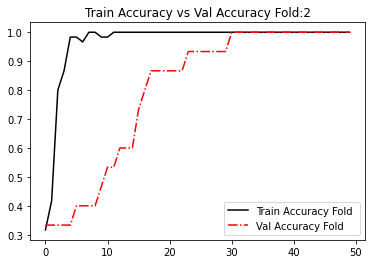

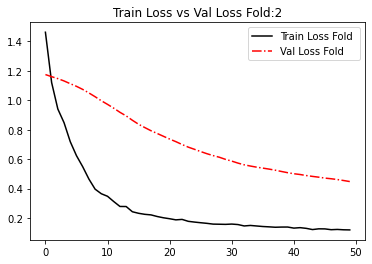

Val-Score for fold 2: loss of 0.5869170427322388; acc of 100.0%
Test-Score for fold 2: loss of 0.5825363397598267; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 731ms/step - loss: 1.2439 - acc: 0.3667 - val_loss: 1.1684 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 611ms/step - loss: 1.0768 - acc: 0.5333 - val_loss: 1.1546 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.40000 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 582ms/step - loss: 0.9701 - acc: 0.8000 - val_loss: 1.1394 - val_acc: 0.5333

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50

INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 41/50
2/2 [==============================] - 1s 580ms/step - loss: 0.1287 - acc: 1.0000 - val_loss: 0.4799 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 573ms/step - loss: 0.1318 - acc: 1.0000 - val_loss: 0.4700 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 576ms/step - loss: 0.1305 - acc: 1.0000 - val_loss: 0.4616 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 623ms/step - loss: 0.1220 - acc: 1.0000 - val_loss: 0.4549 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 588ms/step - loss: 0.1209 - acc: 1.0000 - val_loss: 0.4451 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [============

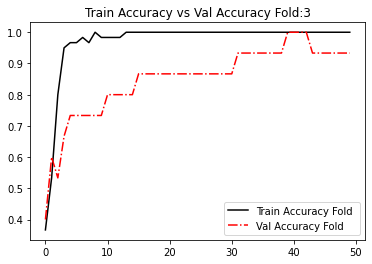

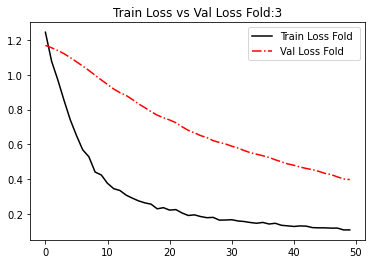

Val-Score for fold 3: loss of 0.48790496587753296; acc of 100.0%
Test-Score for fold 3: loss of 0.4784165322780609; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 689ms/step - loss: 1.2413 - acc: 0.3833 - val_loss: 1.1742 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 589ms/step - loss: 1.0869 - acc: 0.6000 - val_loss: 1.1604 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.46667 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 591ms/step - loss: 0.9220 - acc: 0.8500 - val_loss: 1.1427 - val_acc: 0.8000

Epoch 00003: val_acc improved from 0.60000 to 0

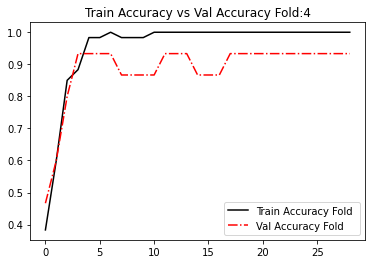

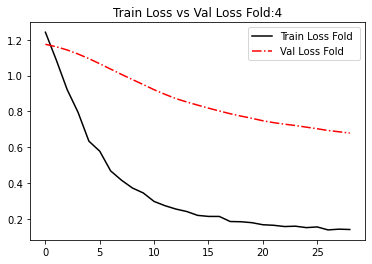

Val-Score for fold 4: loss of 1.1201101541519165; acc of 93.33333373069763%
Test-Score for fold 4: loss of 1.1022289991378784; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 681ms/step - loss: 1.3557 - acc: 0.3500 - val_loss: 1.1680 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 594ms/step - loss: 1.0985 - acc: 0.5167 - val_loss: 1.1528 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.53333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 643ms/step - loss: 0.9127 - acc: 0.8000 - val_loss: 1.1342 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0

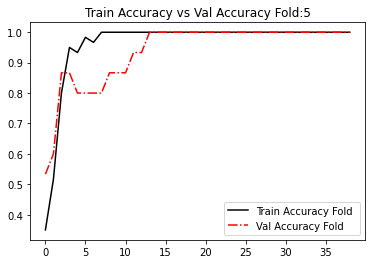

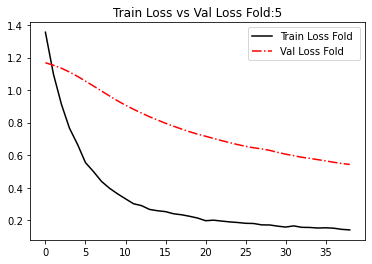

Val-Score for fold 5: loss of 0.8360316157341003; acc of 100.0%
Test-Score for fold 5: loss of 0.8463500142097473; acc of 100.0%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:98.66666674613953 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 687ms/step - loss: 1.4556 - acc: 0.2833 - val_loss: 1.1655 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 590ms/step - loss: 1.0090 - acc: 0.6167 - val_loss: 1.1439 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.46667 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\as

2/2 [==============================] - 1s 597ms/step - loss: 0.1247 - acc: 1.0000 - val_loss: 0.5418 - val_acc: 1.0000

Epoch 00040: val_acc improved from 0.93333 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 41/50
2/2 [==============================] - 1s 573ms/step - loss: 0.1185 - acc: 1.0000 - val_loss: 0.5308 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 607ms/step - loss: 0.1309 - acc: 1.0000 - val_loss: 0.5177 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 577ms/step - loss: 0.1215 - acc: 1.0000 - val_loss: 0.5126 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 583ms/step - loss: 0.1144 - acc: 1.0000 - val_loss: 0.5088 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
E

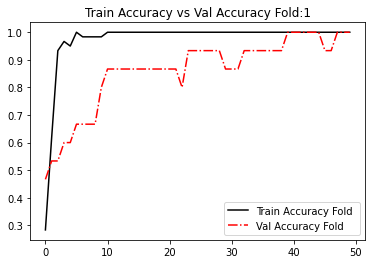

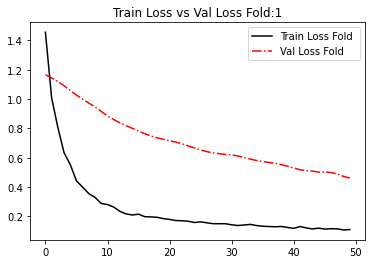

Val-Score for fold 1: loss of 0.5417782068252563; acc of 100.0%
Test-Score for fold 1: loss of 0.44414082169532776; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 753ms/step - loss: 1.2757 - acc: 0.2833 - val_loss: 1.1681 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 638ms/step - loss: 1.1453 - acc: 0.5833 - val_loss: 1.1516 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 683ms/step - loss: 0.9472 - acc: 0.7000 - val_loss: 1.1314 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 639ms/step - loss: 0.8472 - acc: 0.7000 - val

2/2 [==============================] - 1s 597ms/step - loss: 0.1492 - acc: 1.0000 - val_loss: 0.4724 - val_acc: 1.0000

Epoch 00039: val_acc did not improve from 1.00000
Epoch 40/50
2/2 [==============================] - 1s 576ms/step - loss: 0.1456 - acc: 1.0000 - val_loss: 0.4615 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 605ms/step - loss: 0.1406 - acc: 1.0000 - val_loss: 0.4518 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 712ms/step - loss: 0.1397 - acc: 1.0000 - val_loss: 0.4422 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 656ms/step - loss: 0.1350 - acc: 1.0000 - val_loss: 0.4327 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 591ms/step - loss: 0.1390 - acc: 1.0000 - val_lo

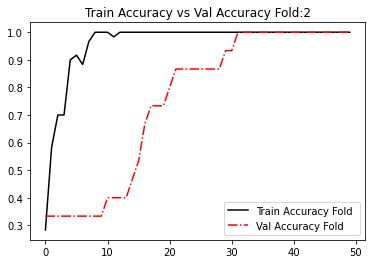

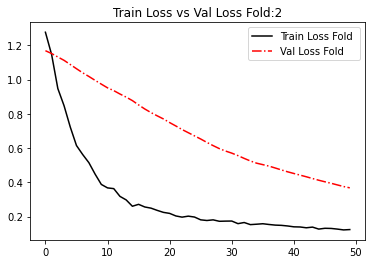

Val-Score for fold 2: loss of 0.555968701839447; acc of 100.0%
Test-Score for fold 2: loss of 0.7554038166999817; acc of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 703ms/step - loss: 1.2518 - acc: 0.4000 - val_loss: 1.1736 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 589ms/step - loss: 1.1405 - acc: 0.3333 - val_loss: 1.1614 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 562ms/step - loss: 0.9709 - acc: 0.8167 - val_loss: 1.1487 - val_acc: 0.5333

Epoch 00003: val_acc did not improve from 0.60000

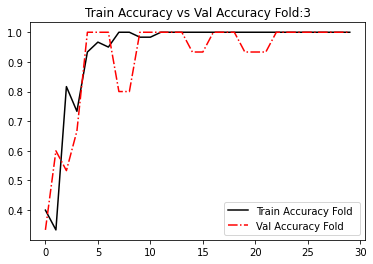

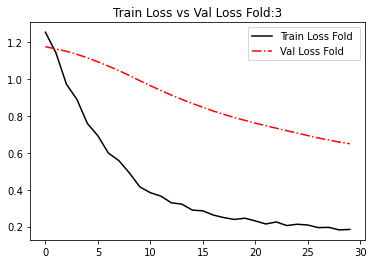

Val-Score for fold 3: loss of 1.1133289337158203; acc of 100.0%
Test-Score for fold 3: loss of 1.120811104774475; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 696ms/step - loss: 1.3128 - acc: 0.4500 - val_loss: 1.1711 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 607ms/step - loss: 1.1321 - acc: 0.3833 - val_loss: 1.1501 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.33333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 579ms/step - loss: 0.9020 - acc: 0.9000 - val_loss: 1.1340 - val_acc: 0.4000

Epoch 00003: val_acc did not improve from 0.80000

2/2 [==============================] - 1s 622ms/step - loss: 0.1214 - acc: 1.0000 - val_loss: 0.5268 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 00042: early stopping


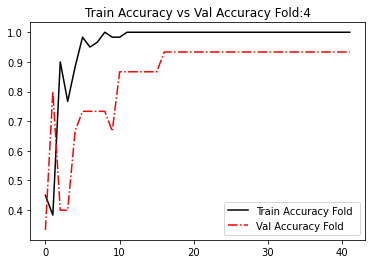

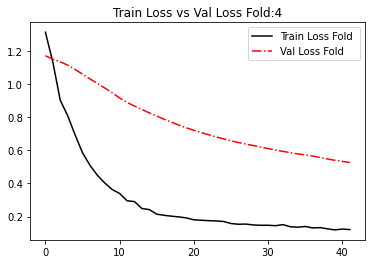

Val-Score for fold 4: loss of 0.7874575853347778; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.7838947176933289; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 727ms/step - loss: 1.2304 - acc: 0.5000 - val_loss: 1.1730 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 604ms/step - loss: 1.0671 - acc: 0.6000 - val_loss: 1.1658 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 626ms/step - loss: 0.9865 - acc: 0.7167 - val_loss: 1.1581 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 665ms/step - loss: 0.8675 - acc: 0

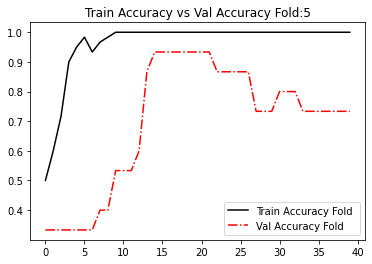

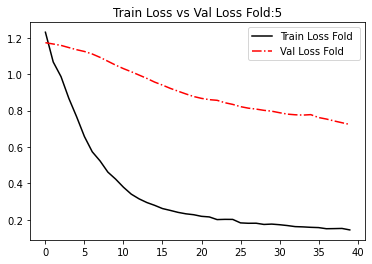

Val-Score for fold 5: loss of 0.9565422534942627; acc of 93.33333373069763%
Test-Score for fold 5: loss of 0.89886474609375; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:97.33333349227905 +- 0.0
Test Accuracy:93.33333373069763 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 719ms/step - loss: 1.2350 - acc: 0.3833 - val_loss: 1.1629 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 672ms/step - loss: 0.9910 - acc: 0.7333 - val_loss: 1.1358 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.66667 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets

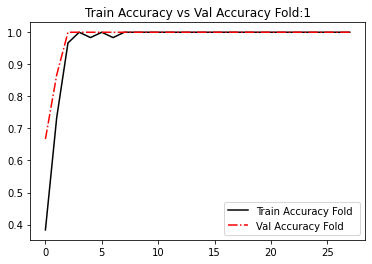

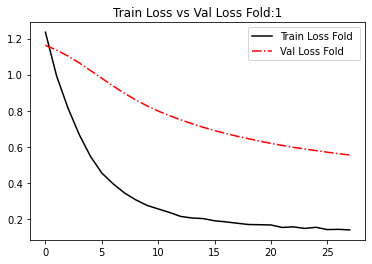

Val-Score for fold 1: loss of 1.103216528892517; acc of 100.0%
Test-Score for fold 1: loss of 1.1188324689865112; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 677ms/step - loss: 1.2415 - acc: 0.3333 - val_loss: 1.1689 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 605ms/step - loss: 1.0429 - acc: 0.6333 - val_loss: 1.1559 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.46667
Epoch 3/50
2/2 [==============================] - 1s 608ms/step - loss: 0.8584 - acc: 1.0000 - val_loss: 1.1406 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.46667
Epoch 4/50
2/2 [==============================] - 1s 628ms/step - loss: 0.7211 - acc: 1.0000 - val_l

2/2 [==============================] - 1s 603ms/step - loss: 0.1223 - acc: 1.0000 - val_loss: 0.6795 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 00041: early stopping


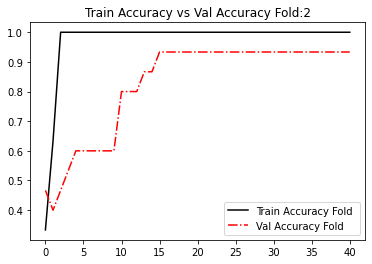

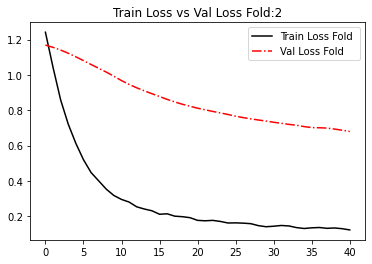

Val-Score for fold 2: loss of 0.8775898218154907; acc of 93.33333373069763%
Test-Score for fold 2: loss of 0.8953400254249573; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 742ms/step - loss: 1.2969 - acc: 0.3500 - val_loss: 1.1740 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 724ms/step - loss: 1.1336 - acc: 0.4833 - val_loss: 1.1586 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 588ms/step - loss: 0.9665 - acc: 0.7833 - val_loss: 1.1445 - val_acc: 0.4000

Epoch 00003: val_acc did not improve 

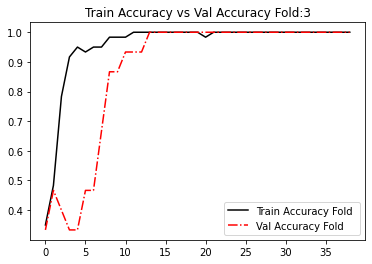

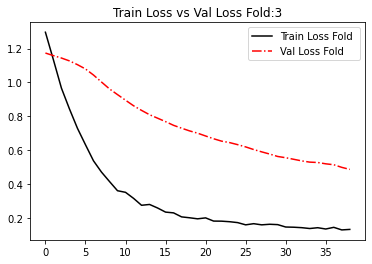

Val-Score for fold 3: loss of 0.8095037341117859; acc of 100.0%
Test-Score for fold 3: loss of 0.8373908996582031; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 1.2986 - acc: 0.350 - 2s 741ms/step - loss: 1.2986 - acc: 0.3500 - val_loss: 1.1629 - val_acc: 0.6667

Epoch 00001: val_acc improved from -inf to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 608ms/step - loss: 1.0819 - acc: 0.4500 - val_loss: 1.1331 - val_acc: 0.6667

Epoch 00002: val_acc did not improve from 0.66667
Epoch 3/50
2/2 [==============================] - 1s 609ms/step - loss: 0.8681 - acc: 0.9500 - val_loss: 1.0984 - val_acc: 0.9333

Epoch 00003: val_acc improved from 0.66667 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Asset

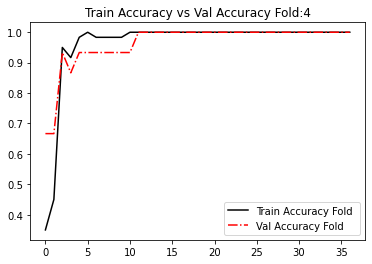

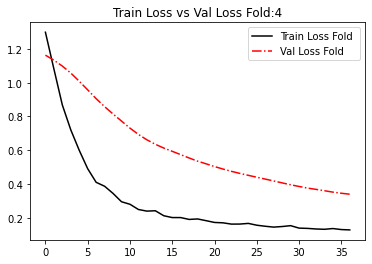

Val-Score for fold 4: loss of 0.6936787366867065; acc of 100.0%
Test-Score for fold 4: loss of 0.7985062003135681; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 813ms/step - loss: 1.2245 - acc: 0.4167 - val_loss: 1.1702 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 962ms/step - loss: 1.0604 - acc: 0.6167 - val_loss: 1.1549 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 671ms/step - loss: 0.8911 - acc: 0.9333 - val_loss: 1.1390 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 670ms/step - loss: 0.7567 - acc: 0.9667 - val_

2/2 [==============================] - 1s 736ms/step - loss: 0.1056 - acc: 1.0000 - val_loss: 0.5666 - val_acc: 0.8000

Epoch 00041: val_acc did not improve from 0.80000
Epoch 42/50
2/2 [==============================] - 1s 771ms/step - loss: 0.1044 - acc: 1.0000 - val_loss: 0.5612 - val_acc: 0.8000

Epoch 00042: val_acc did not improve from 0.80000
Epoch 43/50
2/2 [==============================] - 1s 708ms/step - loss: 0.1077 - acc: 1.0000 - val_loss: 0.5561 - val_acc: 0.8000

Epoch 00043: val_acc did not improve from 0.80000
Epoch 44/50
2/2 [==============================] - 1s 723ms/step - loss: 0.1053 - acc: 1.0000 - val_loss: 0.5526 - val_acc: 0.8000

Epoch 00044: val_acc did not improve from 0.80000
Epoch 45/50
2/2 [==============================] - 1s 775ms/step - loss: 0.1019 - acc: 1.0000 - val_loss: 0.5465 - val_acc: 0.8000

Epoch 00045: val_acc did not improve from 0.80000
Epoch 46/50
2/2 [==============================] - 1s 752ms/step - loss: 0.0991 - acc: 1.0000 - val_lo

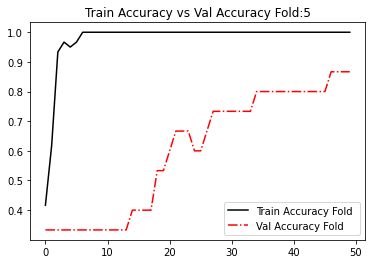

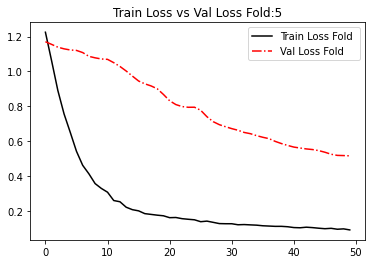

Val-Score for fold 5: loss of 0.5256034135818481; acc of 86.66666746139526%
Test-Score for fold 5: loss of 0.6203931570053101; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:96.00000023841858 +- 0.0
Test Accuracy:93.33333373069763 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 939ms/step - loss: 1.2344 - acc: 0.2500 - val_loss: 1.1697 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 811ms/step - loss: 1.1225 - acc: 0.4833 - val_loss: 1.1619 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 2s 880ms/s

2/2 [==============================] - 1s 720ms/step - loss: 0.1334 - acc: 1.0000 - val_loss: 0.6233 - val_acc: 0.9333

Epoch 00039: val_acc did not improve from 0.93333
Epoch 40/50
2/2 [==============================] - 1s 735ms/step - loss: 0.1326 - acc: 1.0000 - val_loss: 0.6126 - val_acc: 1.0000

Epoch 00040: val_acc improved from 0.93333 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 41/50
2/2 [==============================] - 1s 723ms/step - loss: 0.1268 - acc: 1.0000 - val_loss: 0.6040 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 725ms/step - loss: 0.1319 - acc: 1.0000 - val_loss: 0.5948 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 716ms/step - loss: 0.1330 - acc: 1.0000 - val_loss: 0.5869 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
E

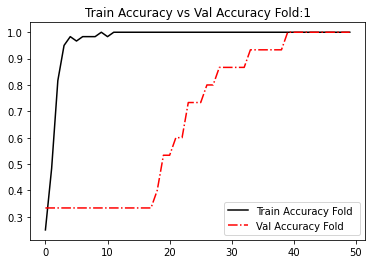

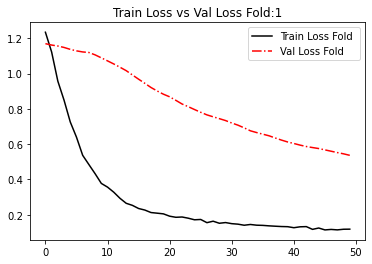

Val-Score for fold 1: loss of 0.6125978827476501; acc of 100.0%
Test-Score for fold 1: loss of 0.6529634594917297; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 854ms/step - loss: 1.3278 - acc: 0.2500 - val_loss: 1.1644 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 817ms/step - loss: 1.0846 - acc: 0.5167 - val_loss: 1.1409 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.40000 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 743ms/step - loss: 0.9199 - acc: 0.8833 - val_loss: 1.1141 - val_acc: 0.7333

Epoch 00003: val_acc improved from 0.60000 to 0.73333, savin

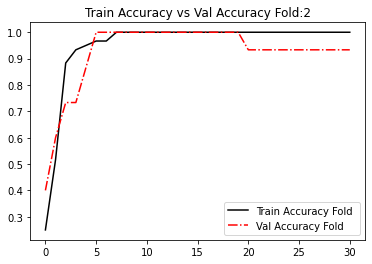

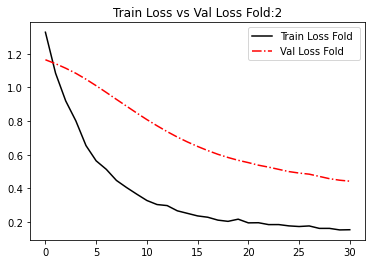

Val-Score for fold 2: loss of 1.0103148221969604; acc of 100.0%
Test-Score for fold 2: loss of 1.038123607635498; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 868ms/step - loss: 1.2371 - acc: 0.2667 - val_loss: 1.1692 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 744ms/step - loss: 1.0931 - acc: 0.4000 - val_loss: 1.1581 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.53333
Epoch 3/50
2/2 [==============================] - 1s 740ms/step - loss: 0.9670 - acc: 0.6500 - val_loss: 1.1546 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.53333
Epoch 4/50
2/2 [==============================] - 1s 777ms/step - loss: 0.8187 - acc: 0.9000 - val_l

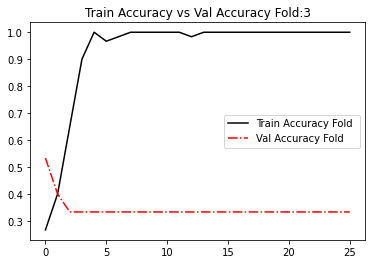

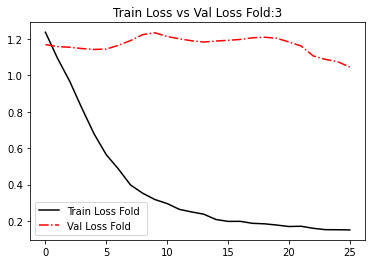

Val-Score for fold 3: loss of 1.1691616773605347; acc of 53.33333611488342%
Test-Score for fold 3: loss of 1.1683846712112427; acc of 46.666666865348816%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 1s/step - loss: 1.4575 - acc: 0.2833 - val_loss: 1.1668 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 818ms/step - loss: 1.1413 - acc: 0.4333 - val_loss: 1.1536 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 731ms/step - loss: 0.9472 - acc: 0.7833 - val_loss: 1.1423 - val_acc: 0.3333

Epoch 00003: val_acc did not improve f

2/2 [==============================] - 1s 709ms/step - loss: 0.1332 - acc: 1.0000 - val_loss: 0.5923 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 707ms/step - loss: 0.1329 - acc: 1.0000 - val_loss: 0.5860 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 719ms/step - loss: 0.1254 - acc: 1.0000 - val_loss: 0.5801 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 748ms/step - loss: 0.1246 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 715ms/step - loss: 0.1214 - acc: 1.0000 - val_loss: 0.5678 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 718ms/step - loss: 0.1199 - acc: 1.0000 - val_lo

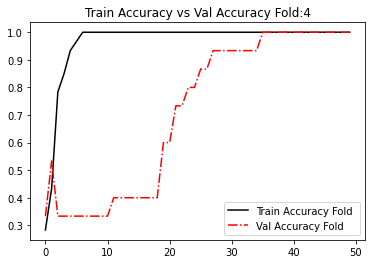

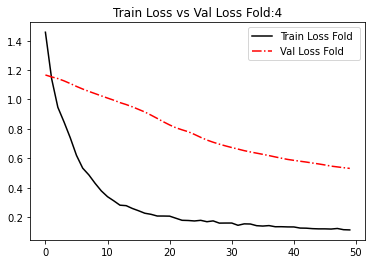

Val-Score for fold 4: loss of 0.6269060373306274; acc of 100.0%
Test-Score for fold 4: loss of 0.6707184314727783; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 3s 1s/step - loss: 1.3642 - acc: 0.3000 - val_loss: 1.1733 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 745ms/step - loss: 1.0340 - acc: 0.5667 - val_loss: 1.1622 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 717ms/step - loss: 0.8323 - acc: 0.9000 - val_loss: 1.1506 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 675ms/step - loss: 0.6931 - acc: 0.9167 - val_los

2/2 [==============================] - 1s 768ms/step - loss: 0.1369 - acc: 1.0000 - val_loss: 0.6477 - val_acc: 0.9333

Epoch 00040: val_acc did not improve from 0.93333
Epoch 41/50
2/2 [==============================] - 1s 759ms/step - loss: 0.1395 - acc: 1.0000 - val_loss: 0.6376 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 776ms/step - loss: 0.1314 - acc: 1.0000 - val_loss: 0.6285 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 2s 809ms/step - loss: 0.1336 - acc: 1.0000 - val_loss: 0.6182 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 786ms/step - loss: 0.1309 - acc: 1.0000 - val_loss: 0.6089 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 767ms/step - loss: 0.1246 - acc: 1.0000 - val_lo

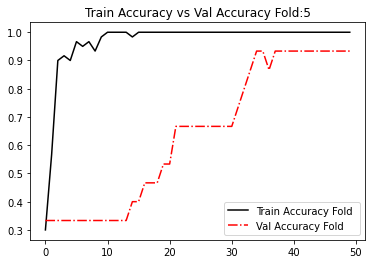

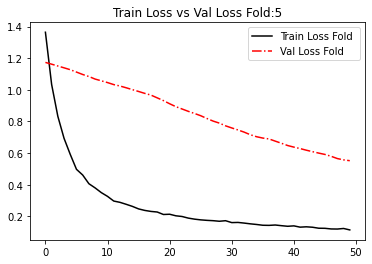

Val-Score for fold 5: loss of 0.7033146619796753; acc of 93.33333373069763%
Test-Score for fold 5: loss of 0.7678039073944092; acc of 86.66666746139526%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:89.33333396911621 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 898ms/step - loss: 1.1749 - acc: 0.4500 - val_loss: 1.1702 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1.0514 - acc: 0.5667 - val_loss: 1.1499 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.46667 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: 

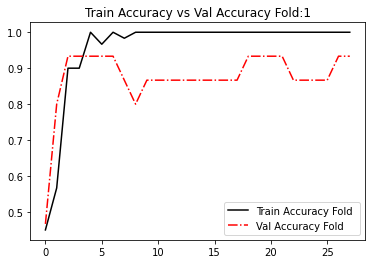

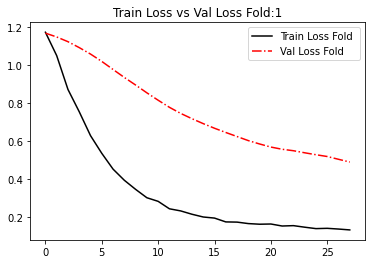

Val-Score for fold 1: loss of 1.1250669956207275; acc of 93.33333373069763%
Test-Score for fold 1: loss of 1.1307754516601562; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 856ms/step - loss: 1.3235 - acc: 0.2833 - val_loss: 1.1670 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 760ms/step - loss: 1.1357 - acc: 0.3833 - val_loss: 1.1455 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.33333 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 730ms/step - loss: 1.0029 - acc: 0.8000 - val_loss: 1.1232 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0

2/2 [==============================] - 1s 792ms/step - loss: 0.1071 - acc: 1.0000 - val_loss: 0.4370 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 773ms/step - loss: 0.1081 - acc: 1.0000 - val_loss: 0.4337 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 754ms/step - loss: 0.1052 - acc: 1.0000 - val_loss: 0.4259 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 745ms/step - loss: 0.1017 - acc: 1.0000 - val_loss: 0.4170 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 00043: early stopping


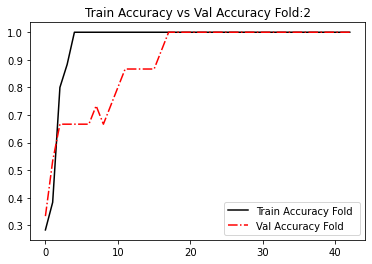

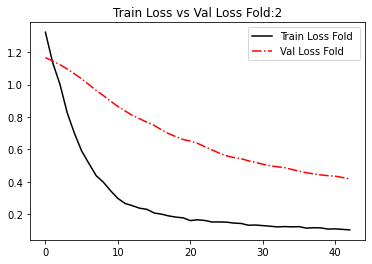

Val-Score for fold 2: loss of 0.696968674659729; acc of 100.0%
Test-Score for fold 2: loss of 0.6261449456214905; acc of 100.0%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 868ms/step - loss: 1.1282 - acc: 0.4333 - val_loss: 1.1684 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 755ms/step - loss: 1.0926 - acc: 0.5167 - val_loss: 1.1518 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 772ms/step - loss: 0.8703 - acc: 0.8833 - val_loss: 1.1345 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.33333
Epoch 4/50
2/2 [==============================] - 1s 772ms/step - loss: 0.7422 - acc: 0.9333 - val_loss: 1.1193 

2/2 [==============================] - 1s 729ms/step - loss: 0.1117 - acc: 1.0000 - val_loss: 0.7307 - val_acc: 0.7333

Epoch 00042: val_acc did not improve from 0.73333
Epoch 43/50
2/2 [==============================] - 1s 774ms/step - loss: 0.1107 - acc: 1.0000 - val_loss: 0.7234 - val_acc: 0.7333

Epoch 00043: val_acc did not improve from 0.73333
Epoch 44/50
2/2 [==============================] - 1s 744ms/step - loss: 0.1042 - acc: 1.0000 - val_loss: 0.7142 - val_acc: 0.7333

Epoch 00044: val_acc did not improve from 0.73333
Epoch 45/50
2/2 [==============================] - 1s 794ms/step - loss: 0.1039 - acc: 1.0000 - val_loss: 0.7152 - val_acc: 0.7333

Epoch 00045: val_acc did not improve from 0.73333
Epoch 46/50
2/2 [==============================] - 1s 750ms/step - loss: 0.1040 - acc: 1.0000 - val_loss: 0.7123 - val_acc: 0.7333

Epoch 00046: val_acc did not improve from 0.73333
Epoch 47/50
2/2 [==============================] - 1s 759ms/step - loss: 0.1043 - acc: 1.0000 - val_lo

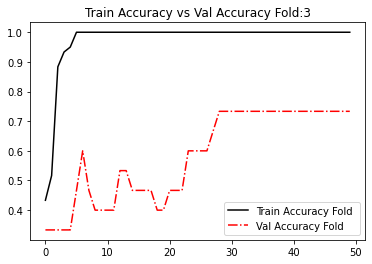

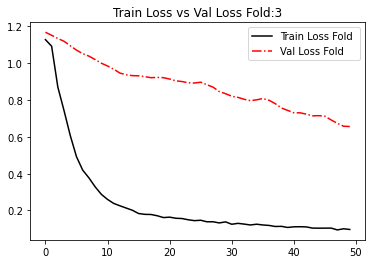

Val-Score for fold 3: loss of 0.8459213376045227; acc of 73.33333492279053%
Test-Score for fold 3: loss of 0.72987961769104; acc of 73.33333492279053%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 863ms/step - loss: 1.3219 - acc: 0.3500 - val_loss: 1.1648 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 770ms/step - loss: 1.0338 - acc: 0.7000 - val_loss: 1.1472 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.46667 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 757ms/step - loss: 0.8515 - acc: 0.9167 - val_loss: 1.1326 - val_acc: 0.6667

Epoch 00003: val_acc did not improve f

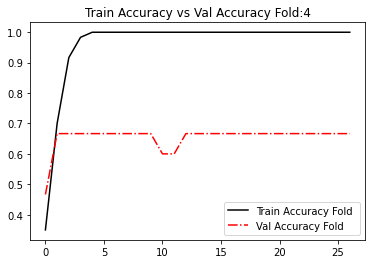

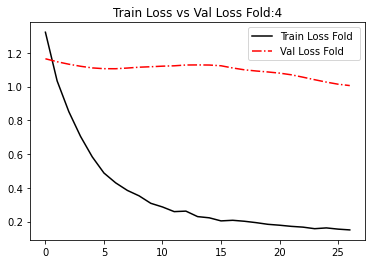

Val-Score for fold 4: loss of 1.1471792459487915; acc of 66.66666865348816%
Test-Score for fold 4: loss of 1.1388953924179077; acc of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 898ms/step - loss: 1.3793 - acc: 0.2333 - val_loss: 1.1666 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 722ms/step - loss: 1.0924 - acc: 0.4000 - val_loss: 1.1531 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.53333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 743ms/step - loss: 0.9583 - acc: 0.8000 - val_loss: 1.1380 - val_acc: 0.6000

Epoch 00003: val_acc did not improve

2/2 [==============================] - 1s 770ms/step - loss: 0.1177 - acc: 1.0000 - val_loss: 0.5127 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 823ms/step - loss: 0.1225 - acc: 1.0000 - val_loss: 0.4969 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 2s 1s/step - loss: 0.1238 - acc: 1.0000 - val_loss: 0.4811 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 2s 804ms/step - loss: 0.1178 - acc: 1.0000 - val_loss: 0.4679 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 2s 1s/step - loss: 0.1157 - acc: 1.0000 - val_loss: 0.4581 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 2s 915ms/step - loss: 0.1111 - acc: 1.0000 - val_loss: 0.

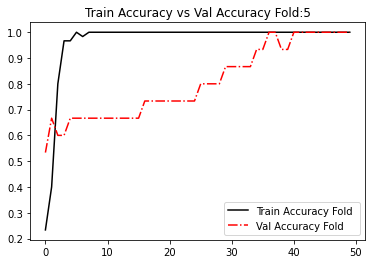

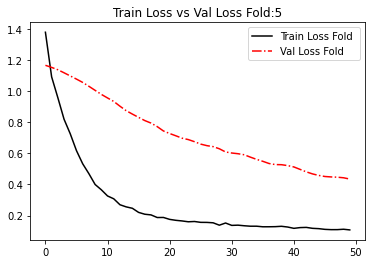

Val-Score for fold 5: loss of 0.5347949862480164; acc of 100.0%
Test-Score for fold 5: loss of 0.5022692084312439; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:86.66666746139526 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 988ms/step - loss: 1.4174 - acc: 0.3000 - val_loss: 1.1706 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 974ms/step - loss: 1.0860 - acc: 0.4333 - val_loss: 1.1593 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 0.8626 - acc: 0

2/2 [==============================] - 1s 773ms/step - loss: 0.1195 - acc: 1.0000 - val_loss: 0.5628 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.86667
Epoch 41/50
2/2 [==============================] - 1s 768ms/step - loss: 0.1192 - acc: 1.0000 - val_loss: 0.5481 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.86667
Epoch 42/50
2/2 [==============================] - 1s 777ms/step - loss: 0.1221 - acc: 1.0000 - val_loss: 0.5394 - val_acc: 0.9333

Epoch 00042: val_acc improved from 0.86667 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 43/50
2/2 [==============================] - 1s 795ms/step - loss: 0.1140 - acc: 1.0000 - val_loss: 0.5309 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 776ms/step - loss: 0.1200 - acc: 1.0000 - val_loss: 0.5272 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.93333
E

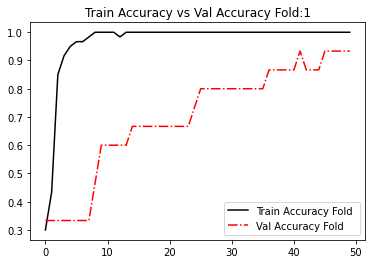

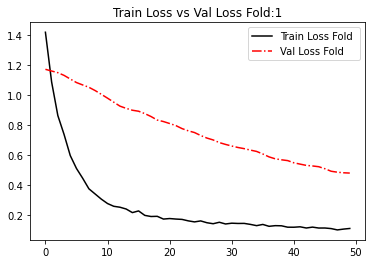

Val-Score for fold 1: loss of 0.5394332408905029; acc of 93.33333373069763%
Test-Score for fold 1: loss of 0.4126075208187103; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 864ms/step - loss: 1.3843 - acc: 0.3000 - val_loss: 1.1662 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 763ms/step - loss: 1.0105 - acc: 0.6500 - val_loss: 1.1456 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.40000 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 742ms/step - loss: 0.8025 - acc: 0.9500 - val_loss: 1.1244 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.53333 to 0.

2/2 [==============================] - 2s 805ms/step - loss: 0.1068 - acc: 1.0000 - val_loss: 0.5164 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.86667
Epoch 42/50
2/2 [==============================] - 2s 977ms/step - loss: 0.1085 - acc: 1.0000 - val_loss: 0.5154 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 2s 1s/step - loss: 0.1091 - acc: 1.0000 - val_loss: 0.5052 - val_acc: 0.8667

Epoch 00043: val_acc did not improve from 0.86667
Epoch 44/50
2/2 [==============================] - 2s 780ms/step - loss: 0.1068 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 0.8667

Epoch 00044: val_acc did not improve from 0.86667
Epoch 45/50
2/2 [==============================] - 1s 792ms/step - loss: 0.1037 - acc: 1.0000 - val_loss: 0.4758 - val_acc: 0.8667

Epoch 00045: val_acc did not improve from 0.86667
Epoch 46/50
2/2 [==============================] - 1s 743ms/step - loss: 0.1029 - acc: 1.0000 - val_loss:

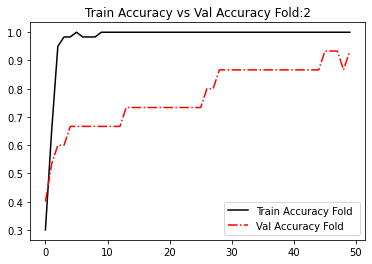

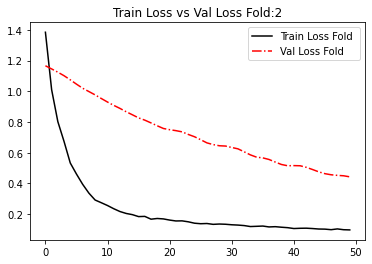

Val-Score for fold 2: loss of 0.4638533592224121; acc of 93.33333373069763%
Test-Score for fold 2: loss of 0.4165796935558319; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 866ms/step - loss: 1.2084 - acc: 0.3833 - val_loss: 1.1703 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 733ms/step - loss: 1.1088 - acc: 0.4000 - val_loss: 1.1556 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.53333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 767ms/step - loss: 0.9492 - acc: 0.8167 - val_loss: 1.1378 - val_acc: 0.6000

Epoch 00003: val_acc did not improve

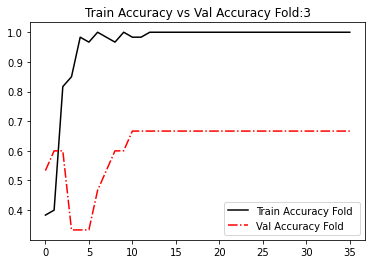

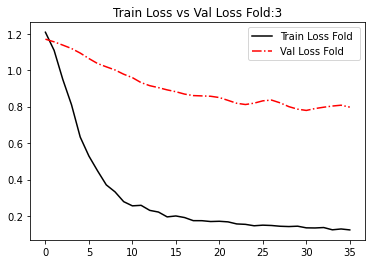

Val-Score for fold 3: loss of 0.9593212604522705; acc of 66.66666865348816%
Test-Score for fold 3: loss of 0.8786904811859131; acc of 73.33333492279053%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 946ms/step - loss: 1.1907 - acc: 0.3833 - val_loss: 1.1647 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 736ms/step - loss: 1.1245 - acc: 0.4167 - val_loss: 1.1384 - val_acc: 0.7333

Epoch 00002: val_acc improved from 0.60000 to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 737ms/step - loss: 0.8290 - acc: 0.9000 - val_loss: 1.1157 - val_acc: 0.6667

Epoch 00003: val_acc did not improve

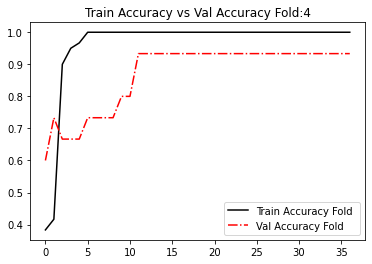

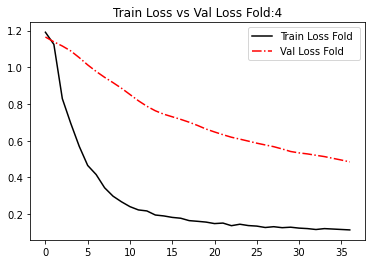

Val-Score for fold 4: loss of 0.8175464868545532; acc of 93.33333373069763%
Test-Score for fold 4: loss of 0.7544323205947876; acc of 100.0%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 1s/step - loss: 1.1931 - acc: 0.3667 - val_loss: 1.1686 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 935ms/step - loss: 1.0710 - acc: 0.3667 - val_loss: 1.1530 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.53333
Epoch 3/50
2/2 [==============================] - 2s 804ms/step - loss: 0.9032 - acc: 0.8833 - val_loss: 1.1374 - val_acc: 0.5333

Epoch 00003: val_acc did not improve from 0.53333
Epoch 4/50
2/2 [==============================] - 2s 821ms/step - loss: 0.8164 - acc: 0.8167 - val_los

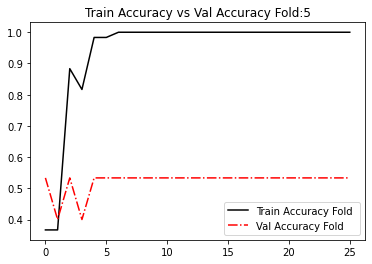

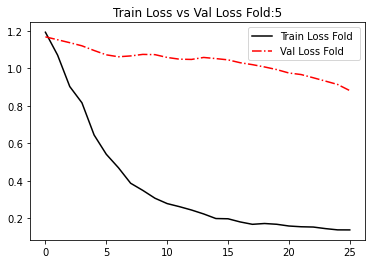

Val-Score for fold 5: loss of 1.1685855388641357; acc of 53.33333611488342%
Test-Score for fold 5: loss of 1.1685765981674194; acc of 46.666666865348816%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:80.0000011920929 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 902ms/step - loss: 1.2273 - acc: 0.3333 - val_loss: 1.1629 - val_acc: 0.7333

Epoch 00001: val_acc improved from -inf to 0.73333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 897ms/step - loss: 1.0350 - acc: 0.6667 - val_loss: 1.1397 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.73333 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written t

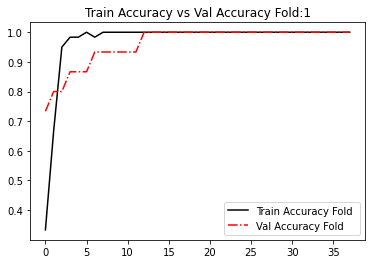

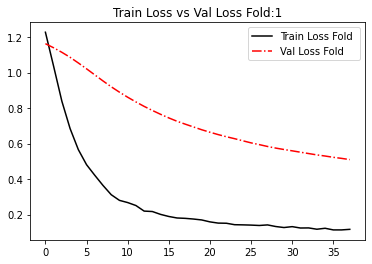

Val-Score for fold 1: loss of 0.8095898032188416; acc of 100.0%
Test-Score for fold 1: loss of 0.843052089214325; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 901ms/step - loss: 1.2370 - acc: 0.4167 - val_loss: 1.1707 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 736ms/step - loss: 1.1081 - acc: 0.5833 - val_loss: 1.1548 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 726ms/step - loss: 0.9013 - acc: 0.8333 - val_loss: 1.1366 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50


2/2 [==============================] - 1s 740ms/step - loss: 0.1002 - acc: 1.0000 - val_loss: 0.5830 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 750ms/step - loss: 0.1027 - acc: 1.0000 - val_loss: 0.5723 - val_acc: 0.9333

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 756ms/step - loss: 0.0999 - acc: 1.0000 - val_loss: 0.5619 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 749ms/step - loss: 0.0983 - acc: 1.0000 - val_loss: 0.5561 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 747ms/step - loss: 0.0962 - acc: 1.0000 - val_loss: 0.5536 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 0.93333
Epoch 46/50
2/2 [==============================] - 1s 741ms/step - loss: 0.0971 - acc: 1.0000 - val_lo

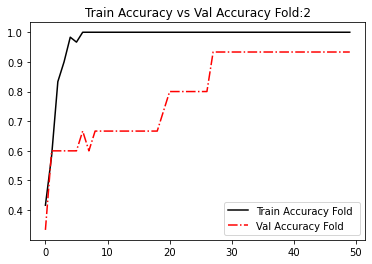

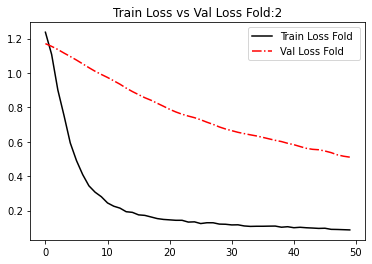

Val-Score for fold 2: loss of 0.7010973691940308; acc of 93.33333373069763%
Test-Score for fold 2: loss of 0.6880469918251038; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 1s/step - loss: 1.3761 - acc: 0.3000 - val_loss: 1.1634 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 771ms/step - loss: 1.0889 - acc: 0.5167 - val_loss: 1.1401 - val_acc: 0.8667

Epoch 00002: val_acc improved from 0.46667 to 0.86667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 854ms/step - loss: 0.9658 - acc: 0.7667 - val_loss: 1.1163 - val_acc: 0.8000

Epoch 00003: val_acc did not improve fr

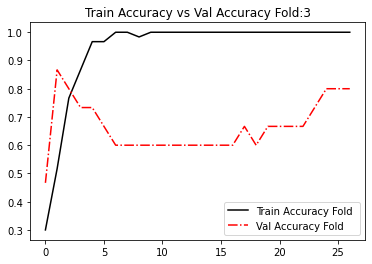

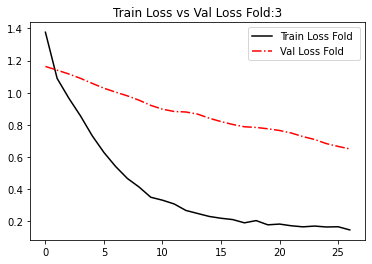

Val-Score for fold 3: loss of 1.1401044130325317; acc of 86.66666746139526%
Test-Score for fold 3: loss of 1.1455848217010498; acc of 60.00000238418579%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 923ms/step - loss: 1.2577 - acc: 0.4333 - val_loss: 1.1651 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 747ms/step - loss: 1.0295 - acc: 0.6000 - val_loss: 1.1454 - val_acc: 0.6000

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/50
2/2 [==============================] - 1s 758ms/step - loss: 0.8306 - acc: 0.8667 - val_loss: 1.1272 - val_acc: 0.6000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50
2/2 [==============================] - 1s 761ms/step - loss: 0.6825 - acc: 0

2/2 [==============================] - 1s 737ms/step - loss: 0.1052 - acc: 1.0000 - val_loss: 0.5629 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 848ms/step - loss: 0.1023 - acc: 1.0000 - val_loss: 0.5568 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 2s 838ms/step - loss: 0.1023 - acc: 1.0000 - val_loss: 0.5515 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 766ms/step - loss: 0.1028 - acc: 1.0000 - val_loss: 0.5459 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 738ms/step - loss: 0.0992 - acc: 1.0000 - val_loss: 0.5407 - val_acc: 1.0000

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
2/2 [==============================] - 2s 1s/step - loss: 0.0994 - acc: 1.0000 - val_loss:

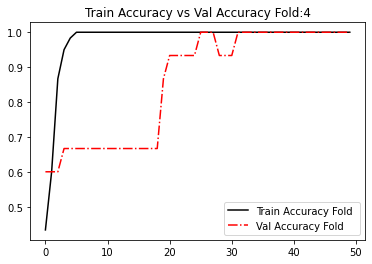

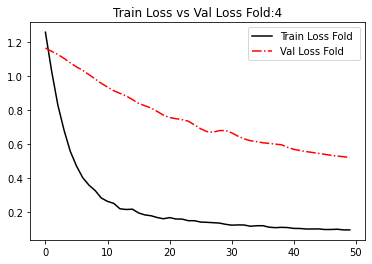

Val-Score for fold 4: loss of 0.6908132433891296; acc of 100.0%
Test-Score for fold 4: loss of 0.6750050783157349; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 902ms/step - loss: 1.3778 - acc: 0.2333 - val_loss: 1.1699 - val_acc: 0.5333

Epoch 00001: val_acc improved from -inf to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1.0417 - acc: 0.6667 - val_loss: 1.1566 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.53333
Epoch 3/50
2/2 [==============================] - 2s 868ms/step - loss: 0.8855 - acc: 0.9000 - val_loss: 1.1438 - val_acc: 0.3333

Epoch 00003: val_acc did not improve from 0.53333
Epoch 4/50
2/2 [==============================] - 2s 820ms/step - loss: 0.7685 - acc: 0.9333 - val_los

2/2 [==============================] - 1s 746ms/step - loss: 0.1079 - acc: 1.0000 - val_loss: 0.6627 - val_acc: 0.9333

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 781ms/step - loss: 0.1043 - acc: 1.0000 - val_loss: 0.6545 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 758ms/step - loss: 0.1039 - acc: 1.0000 - val_loss: 0.6476 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 739ms/step - loss: 0.1034 - acc: 1.0000 - val_loss: 0.6399 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 777ms/step - loss: 0.0987 - acc: 1.0000 - val_loss: 0.6318 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 750ms/step - loss: 0.0981 - acc: 1.0000 - val_lo

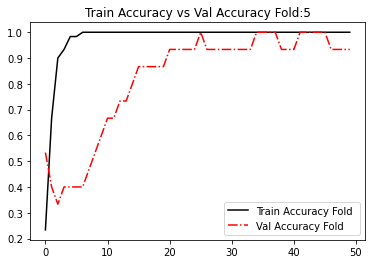

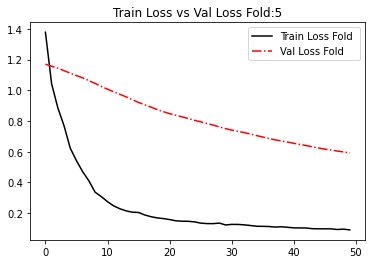

Val-Score for fold 5: loss of 0.7945762872695923; acc of 100.0%
Test-Score for fold 5: loss of 0.7496064901351929; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:96.00000023841858 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 943ms/step - loss: 1.3570 - acc: 0.2500 - val_loss: 1.1625 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 917ms/step - loss: 1.0165 - acc: 0.6500 - val_loss: 1.1402 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.46667 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_c

2/2 [==============================] - 1s 720ms/step - loss: 0.1079 - acc: 1.0000 - val_loss: 0.3859 - val_acc: 1.0000

Epoch 00040: val_acc did not improve from 1.00000
Epoch 41/50
2/2 [==============================] - 1s 746ms/step - loss: 0.1059 - acc: 1.0000 - val_loss: 0.3862 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 735ms/step - loss: 0.0979 - acc: 1.0000 - val_loss: 0.3820 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 729ms/step - loss: 0.1006 - acc: 1.0000 - val_loss: 0.3661 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 746ms/step - loss: 0.0972 - acc: 1.0000 - val_loss: 0.3517 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 775ms/step - loss: 0.0991 - acc: 1.0000 - val_lo

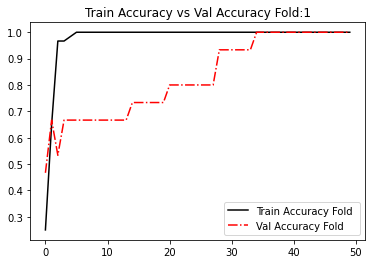

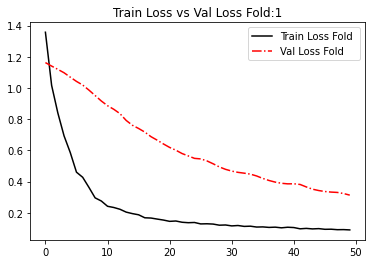

Val-Score for fold 1: loss of 0.43635982275009155; acc of 100.0%
Test-Score for fold 1: loss of 0.4719823896884918; acc of 100.0%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 876ms/step - loss: 1.3203 - acc: 0.3667 - val_loss: 1.1669 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 748ms/step - loss: 1.0710 - acc: 0.5500 - val_loss: 1.1533 - val_acc: 0.6000

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/50
2/2 [==============================] - 1s 729ms/step - loss: 0.8789 - acc: 0.8667 - val_loss: 1.1410 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.60000 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 4/5

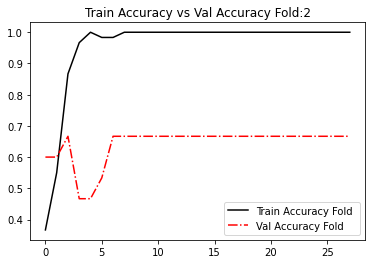

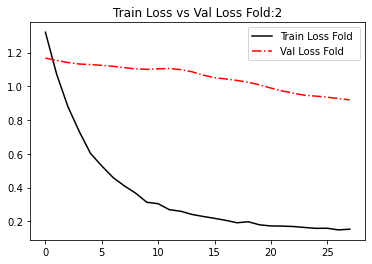

Val-Score for fold 2: loss of 1.141018271446228; acc of 66.66666865348816%
Test-Score for fold 2: loss of 1.140634536743164; acc of 60.00000238418579%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 861ms/step - loss: 1.3847 - acc: 0.3333 - val_loss: 1.1661 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 779ms/step - loss: 1.0670 - acc: 0.4667 - val_loss: 1.1506 - val_acc: 0.4667

Epoch 00002: val_acc improved from 0.33333 to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 733ms/step - loss: 0.8628 - acc: 0.9167 - val_loss: 1.1343 - val_acc: 0.6000

Epoch 00003: val_acc improved from 0.4

2/2 [==============================] - 1s 735ms/step - loss: 0.1119 - acc: 1.0000 - val_loss: 0.5944 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.93333
Epoch 41/50
2/2 [==============================] - 1s 766ms/step - loss: 0.1222 - acc: 1.0000 - val_loss: 0.5938 - val_acc: 0.9333

Epoch 00041: val_acc did not improve from 0.93333
Epoch 42/50
2/2 [==============================] - 1s 739ms/step - loss: 0.1151 - acc: 1.0000 - val_loss: 0.5966 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.93333
Epoch 43/50
2/2 [==============================] - 1s 752ms/step - loss: 0.1129 - acc: 1.0000 - val_loss: 0.5873 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 0.93333
Epoch 44/50
2/2 [==============================] - 1s 750ms/step - loss: 0.1082 - acc: 1.0000 - val_loss: 0.5808 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 0.93333
Epoch 45/50
2/2 [==============================] - 1s 723ms/step - loss: 0.1144 - acc: 1.0000 - val_lo

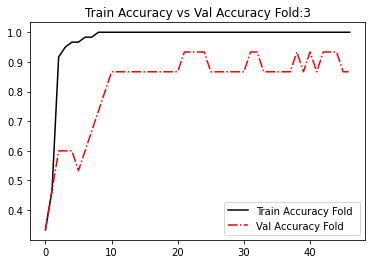

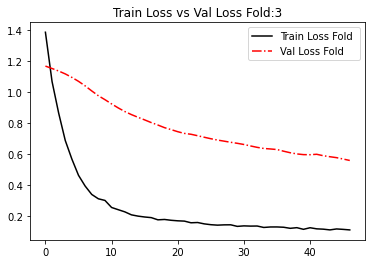

Val-Score for fold 3: loss of 0.7313677072525024; acc of 93.33333373069763%
Test-Score for fold 3: loss of 0.7057958245277405; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 849ms/step - loss: 1.3737 - acc: 0.4000 - val_loss: 1.1690 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 831ms/step - loss: 1.0874 - acc: 0.4833 - val_loss: 1.1496 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 728ms/step - loss: 0.8790 - acc: 0.8333 - val_loss: 1.1313 - val_acc: 0.5333

Epoch 00003: val_acc did not improve

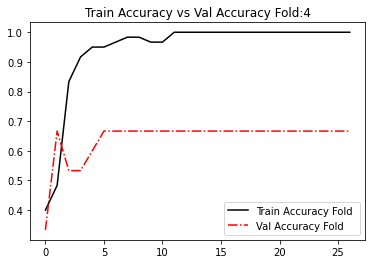

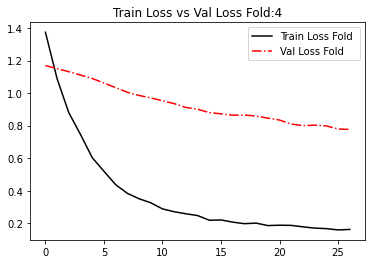

Val-Score for fold 4: loss of 1.1496464014053345; acc of 66.66666865348816%
Test-Score for fold 4: loss of 1.1482415199279785; acc of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 899ms/step - loss: 1.5961 - acc: 0.2500 - val_loss: 1.1586 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 732ms/step - loss: 1.0147 - acc: 0.5667 - val_loss: 1.1227 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.33333 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 750ms/step - loss: 0.8178 - acc: 0.9333 - val_loss: 1.0846 - val_acc: 1.0000

Epoch 00003: val_acc did not improve

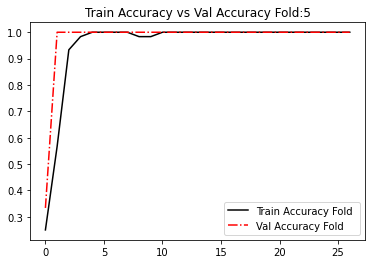

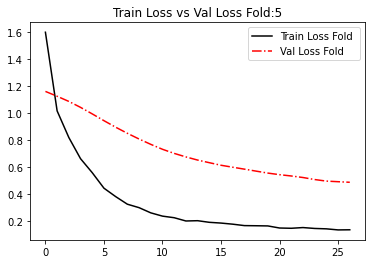

Val-Score for fold 5: loss of 1.122728705406189; acc of 100.0%
Test-Score for fold 5: loss of 1.1354386806488037; acc of 73.33333492279053%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:85.33333420753479 +- 0.0
Test Accuracy:100.0 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 2s 976ms/step - loss: 1.4488 - acc: 0.2833 - val_loss: 1.1659 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 790ms/step - loss: 1.0698 - acc: 0.6000 - val_loss: 1.1425 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_ch

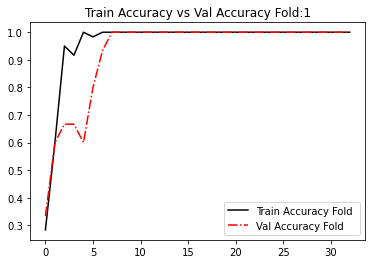

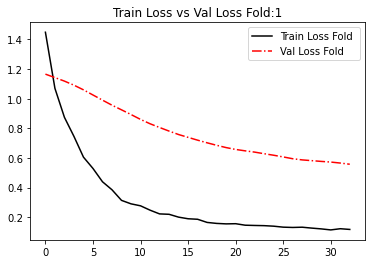

Val-Score for fold 1: loss of 0.9562264680862427; acc of 100.0%
Test-Score for fold 1: loss of 0.9573613405227661; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 874ms/step - loss: 1.1799 - acc: 0.3333 - val_loss: 1.1636 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 757ms/step - loss: 1.1317 - acc: 0.4167 - val_loss: 1.1361 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.33333 to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 778ms/step - loss: 0.9062 - acc: 0.8167 - val_loss: 1.1038 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.40000 to 0.

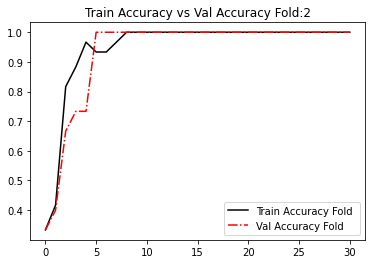

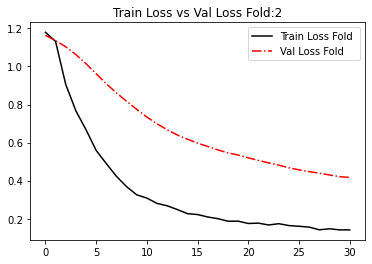

Val-Score for fold 2: loss of 0.9619184732437134; acc of 100.0%
Test-Score for fold 2: loss of 1.018434762954712; acc of 80.0000011920929%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 906ms/step - loss: 1.1567 - acc: 0.3833 - val_loss: 1.1704 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 758ms/step - loss: 1.1050 - acc: 0.5000 - val_loss: 1.1534 - val_acc: 0.5333

Epoch 00002: val_acc improved from 0.40000 to 0.53333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 744ms/step - loss: 0.9631 - acc: 0.8667 - val_loss: 1.1337 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.53333


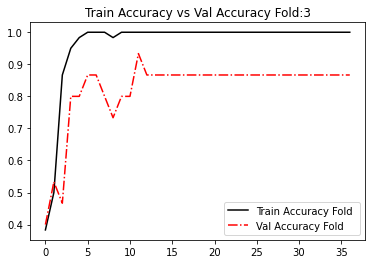

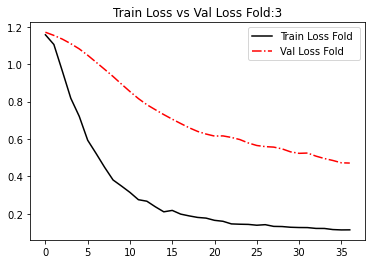

Val-Score for fold 3: loss of 0.815891444683075; acc of 93.33333373069763%
Test-Score for fold 3: loss of 0.818923830986023; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 881ms/step - loss: 1.2186 - acc: 0.3500 - val_loss: 1.1696 - val_acc: 0.4667

Epoch 00001: val_acc improved from -inf to 0.46667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 775ms/step - loss: 1.0525 - acc: 0.5500 - val_loss: 1.1511 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.46667 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 739ms/step - loss: 0.8760 - acc: 0.9500 - val_loss: 1.1307 - val_acc: 0.6667

Epoch 00003: val_acc did not improve f

2/2 [==============================] - 1s 767ms/step - loss: 0.1022 - acc: 1.0000 - val_loss: 0.5526 - val_acc: 1.0000

Epoch 00042: val_acc improved from 0.93333 to 1.00000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 43/50
2/2 [==============================] - 2s 1s/step - loss: 0.1030 - acc: 1.0000 - val_loss: 0.5499 - val_acc: 0.9333

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 2s 866ms/step - loss: 0.0964 - acc: 1.0000 - val_loss: 0.5486 - val_acc: 0.9333

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 2s 807ms/step - loss: 0.0997 - acc: 1.0000 - val_loss: 0.5433 - val_acc: 0.9333

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 2s 989ms/step - loss: 0.0960 - acc: 1.0000 - val_loss: 0.5335 - val_acc: 0.9333

Epoch 00046: val_acc did not improve from 1.00000
Epoc

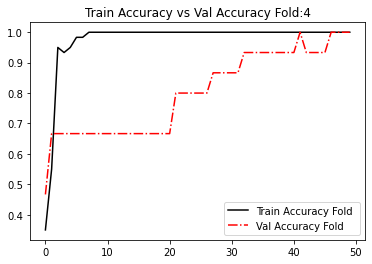

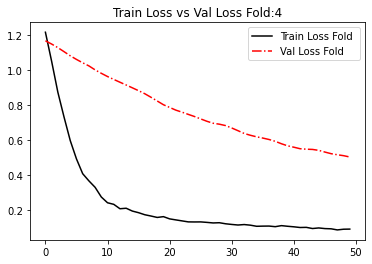

Val-Score for fold 4: loss of 0.5526236295700073; acc of 100.0%
Test-Score for fold 4: loss of 0.5635361075401306; acc of 86.66666746139526%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 864ms/step - loss: 1.3804 - acc: 0.2333 - val_loss: 1.1698 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 779ms/step - loss: 1.1459 - acc: 0.3500 - val_loss: 1.1486 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.33333 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 756ms/step - loss: 0.9663 - acc: 0.7500 - val_loss: 1.1397 - val_acc: 0.4667

Epoch 00003: val_acc did not improve from 0.6000

2/2 [==============================] - 1s 739ms/step - loss: 0.1418 - acc: 1.0000 - val_loss: 0.4196 - val_acc: 1.0000

Epoch 00041: val_acc did not improve from 1.00000
Epoch 42/50
2/2 [==============================] - 1s 733ms/step - loss: 0.1370 - acc: 1.0000 - val_loss: 0.4124 - val_acc: 1.0000

Epoch 00042: val_acc did not improve from 1.00000
Epoch 43/50
2/2 [==============================] - 1s 746ms/step - loss: 0.1362 - acc: 1.0000 - val_loss: 0.4047 - val_acc: 1.0000

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/50
2/2 [==============================] - 1s 752ms/step - loss: 0.1358 - acc: 1.0000 - val_loss: 0.3985 - val_acc: 1.0000

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/50
2/2 [==============================] - 1s 764ms/step - loss: 0.1396 - acc: 1.0000 - val_loss: 0.3878 - val_acc: 1.0000

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
2/2 [==============================] - 1s 767ms/step - loss: 0.1295 - acc: 1.0000 - val_lo

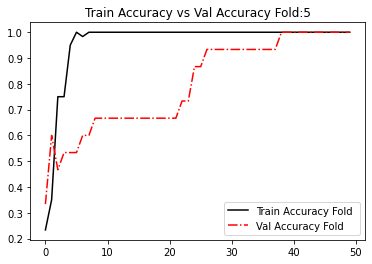

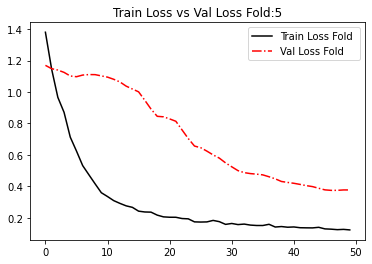

Val-Score for fold 5: loss of 0.43108147382736206; acc of 100.0%
Test-Score for fold 5: loss of 0.4851822853088379; acc of 93.33333373069763%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:98.66666674613953 +- 0.0
Test Accuracy:93.33333373069763 +- 0.0
Found 15 images belonging to 3 classes.
------------------------------------------------------------------------
Training for fold 1 and Validating with Chn 2
Epoch 1/50
2/2 [==============================] - 2s 840ms/step - loss: 1.3628 - acc: 0.2500 - val_loss: 1.1745 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 643ms/step - loss: 1.0965 - acc: 0.5333 - val_loss: 1.1570 - val_acc: 0.3333

Epoch 00002: val_acc did not improve from 0.33333
Epoch 3/50
2/2 [==============================] - 1s 670ms/step - loss:


Epoch 00039: val_acc did not improve from 0.86667
Epoch 40/50
2/2 [==============================] - 1s 715ms/step - loss: 0.1069 - acc: 1.0000 - val_loss: 0.5415 - val_acc: 0.8667

Epoch 00040: val_acc did not improve from 0.86667
Epoch 41/50
2/2 [==============================] - 1s 644ms/step - loss: 0.1003 - acc: 1.0000 - val_loss: 0.5264 - val_acc: 0.8667

Epoch 00041: val_acc did not improve from 0.86667
Epoch 42/50
2/2 [==============================] - 1s 675ms/step - loss: 0.1077 - acc: 1.0000 - val_loss: 0.5162 - val_acc: 0.8667

Epoch 00042: val_acc did not improve from 0.86667
Epoch 43/50
2/2 [==============================] - 1s 729ms/step - loss: 0.1054 - acc: 1.0000 - val_loss: 0.5078 - val_acc: 0.9333

Epoch 00043: val_acc improved from 0.86667 to 0.93333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 44/50
2/2 [==============================] - 1s 683ms/step - loss: 0.1033 - acc: 1.0000 - val_loss: 0.4904 - val_a

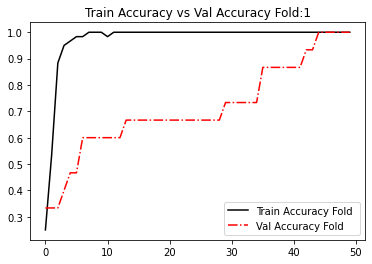

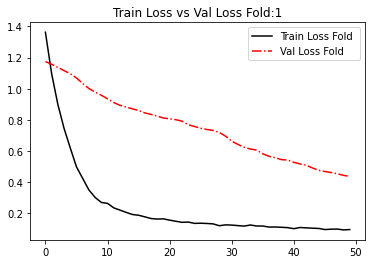

Val-Score for fold 1: loss of 0.47519877552986145; acc of 100.0%
Test-Score for fold 1: loss of 0.5209426879882812; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 2 and Validating with Chn 3
Epoch 1/50
2/2 [==============================] - 4s 1s/step - loss: 1.3289 - acc: 0.2500 - val_loss: 1.1658 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 835ms/step - loss: 1.1036 - acc: 0.4667 - val_loss: 1.1498 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 2s 884ms/step - loss: 0.8849 - acc: 0.7833 - val_loss: 1.1490 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667


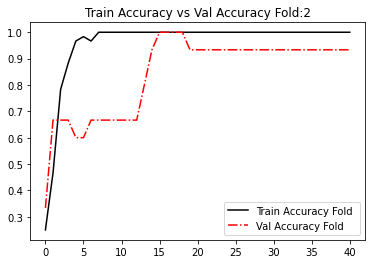

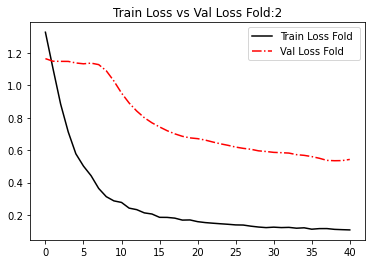

Val-Score for fold 2: loss of 0.7438020706176758; acc of 100.0%
Test-Score for fold 2: loss of 0.745337724685669; acc of 93.33333373069763%
------------------------------------------------------------------------
Training for fold 3 and Validating with Chn 4
Epoch 1/50
2/2 [==============================] - 2s 831ms/step - loss: 1.1840 - acc: 0.4000 - val_loss: 1.1482 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 762ms/step - loss: 0.9908 - acc: 0.6833 - val_loss: 1.1092 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.60000 to 0.80000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 709ms/step - loss: 0.7606 - acc: 0.9667 - val_loss: 1.0637 - val_acc: 0.8667

Epoch 00003: val_acc improved from 0.80000 to 0.8

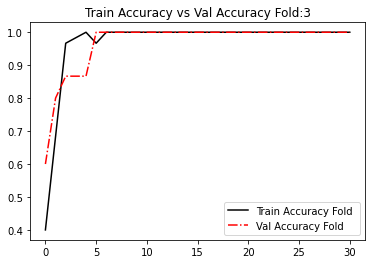

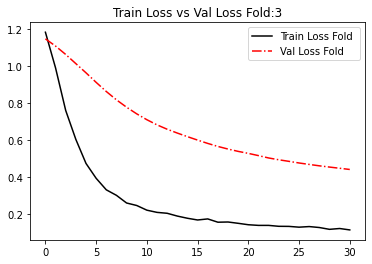

Val-Score for fold 3: loss of 0.9127870202064514; acc of 100.0%
Test-Score for fold 3: loss of 0.9895514249801636; acc of 100.0%
------------------------------------------------------------------------
Training for fold 4 and Validating with Chn 5
Epoch 1/50
2/2 [==============================] - 2s 907ms/step - loss: 1.2565 - acc: 0.3667 - val_loss: 1.1677 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 2s 981ms/step - loss: 1.1621 - acc: 0.3500 - val_loss: 1.1517 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.33333 to 0.66667, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 736ms/step - loss: 0.9690 - acc: 0.7833 - val_loss: 1.1374 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/50

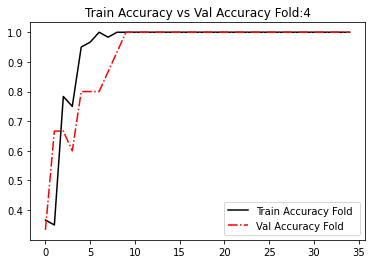

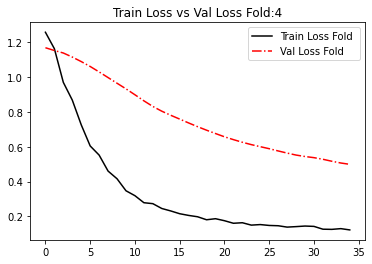

Val-Score for fold 4: loss of 0.9317495226860046; acc of 100.0%
Test-Score for fold 4: loss of 1.0013489723205566; acc of 66.66666865348816%
------------------------------------------------------------------------
Training for fold 5 and Validating with Chn 1
Epoch 1/50
2/2 [==============================] - 2s 846ms/step - loss: 1.2520 - acc: 0.4000 - val_loss: 1.1661 - val_acc: 0.4000

Epoch 00001: val_acc improved from -inf to 0.40000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 2/50
2/2 [==============================] - 1s 697ms/step - loss: 1.0491 - acc: 0.5333 - val_loss: 1.1501 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.40000 to 0.60000, saving model to .\model_checkpoint
INFO:tensorflow:Assets written to: .\model_checkpoint\assets
Epoch 3/50
2/2 [==============================] - 1s 687ms/step - loss: 0.9063 - acc: 0.8833 - val_loss: 1.1326 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.60000 to 0.

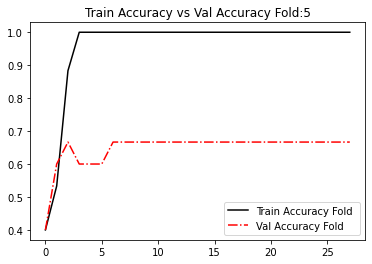

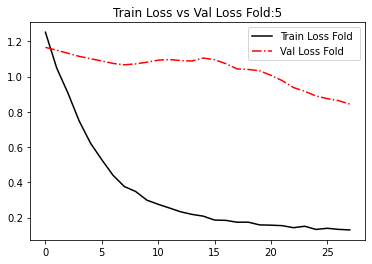

Val-Score for fold 5: loss of 1.1326097249984741; acc of 66.66666865348816%
Test-Score for fold 5: loss of 1.1340224742889404; acc of 66.66666865348816%
******************
Precision por run
**************************
*Val_acc --------Test_acc*
Val Accuracy:93.33333373069763 +- 0.0
Test Accuracy:100.0 +- 0.0


['Val: 0.8800000071525573 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 1.0 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.9600000023841858 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 1.0 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 1.0 +- 0.0 // Test: 0.8666666746139526 +- 0.0',
 'Val: 0.9600000023841858 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.9866666674613953 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.946666669845581 +- 0.0 // Test: 0.9333333373069763 +- 0.0',
 'Val: 0.9600000023841858 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.9333333373069763 +- 0.0 // Test: 0.800000011920929 +- 0.0',
 'Val: 0.9866666674613953 +- 0.0 // Test: 0.9333333373069763 +- 0.0',
 'Val: 0.946666669845581 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.946666669845581 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.826666671037674 +- 0.0 // Test: 0.8666666746139526 +- 0.0',
 'Val: 0.9866666674613953 +- 0.0 // Test: 1.0 +- 0.0',
 'Val: 0.9733333349227905 +- 0.0 // Test: 0.9333333373069763 +- 0.0',
 'Val: 0.9600000023841858 +- 0.0 // Test: 0.9333333373069763 +- 0.0',
 'Val: 0.8

In [11]:
resultados_finales = []
num_test = 24
num_class = 3
repetitions = 1

for i in range(num_test):
    dir_task = r'C:\Users\Lenovo\Documents\UTEC\Ciclo 7\ProyectoCNN\Python\Dataset\Test' + str(i+1)
    X_train,X_test,Y_train,Y_test = get_dataset_v2(dir_task,num_class)
    val_mean,val_std,test_mean,test_std = Kcross_validation_v2(num_class,X_train,X_test,Y_train,Y_test,repetitions)
    resultados_finales.append(f'Val: {val_mean} +- {val_std} // Test: {test_mean} +- {test_std}')
    
resultados_finales